# MNIST Pruning Toy Example
We demonstrate making a simple MLP network pre-trained on MNIST more unadaptable to fine-tuning on Fashion-MNIST by using pruning.

## Imports

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

import chart_utils

## Config

In [155]:
# Hyperparameters
batch_size = 128
test_batch_size = 1000
pt_epochs = 8
ft_epochs = 1
default_lr = 1e-3
gamma = 0.7
seed = 66

# Check for CUDA
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using {device} device")


Using cuda device


## Set Up Data and Models

In [3]:
# Data loaders for MNIST and Fashion-MNIST
mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]  # MNIST stats
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data",
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]  # MNIST stats
        ),
    ),
    batch_size=test_batch_size,
    shuffle=True,
)

fashion_train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.2860,), (0.3530,))]  # Fashion-MNIST stats
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

fashion_test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data",
        train=False,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.2860,), (0.3530,))]  # Fashion-MNIST stats
        ),
    ),
    batch_size=test_batch_size,
    shuffle=True,
)

print(f"Loaded {len(mnist_train_loader.dataset)} MNIST training samples\n{len(mnist_test_loader.dataset)} MNIST test samples\n{len(fashion_train_loader.dataset)} Fashion-MNIST training samples\n{len(fashion_test_loader.dataset)} Fashion-MNIST test samples")


Loaded 60000 MNIST training samples
10000 MNIST test samples
60000 Fashion-MNIST training samples
10000 Fashion-MNIST test samples


In [4]:
# Define and initialize the model

class MLPNet(nn.Module):
    """N-layer MLP model with dropout."""
    def __init__(self, hidden_layer_dims=[1024, 1024], dropout=0.2):
        super(MLPNet, self).__init__()
        # Dynamically create layers based on hidden_layer_dims
        prev_dim = 784
        layers = []
        for dim in hidden_layer_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))  # TODO test without
            prev_dim = dim
        layers.append(nn.Linear(prev_dim, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.layers(x)
        return F.log_softmax(x, dim=1)


# Initialize the model
model_inital = MLPNet().to(device)


In [157]:
def train(model, device, train_loader, num_epochs=pt_epochs, learning_rate=default_lr, step_gamma=gamma):
    """
    Training function.

    Returns a list of losses.
    """
    # Reset train loader seed for consistency
    train_loader.sampler.generator = torch.Generator().manual_seed(seed)

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=step_gamma)
    model.train()
    num_total_batches = len(train_loader) * num_epochs
    progress_bar = tqdm(total=num_total_batches, position=0, leave=True)
    losses = []
    for epoch in range(1, num_epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            progress_bar.update(1)
            losses.append(loss.item())
        if epoch % 1 == 0 or epoch == num_epochs:
            # Avg loss over this epoch
            avg_loss = sum(losses[-len(train_loader) :]) / len(train_loader)
            print(
                f"Train Epoch: {epoch}/{num_epochs} ({100 * epoch / num_epochs:.2f}%) Average Loss: {avg_loss:.6f}"
            )
        scheduler.step()
    progress_bar.close()
    return losses


def test(model, device, test_loader):
    """Testing function."""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction="sum").item()
            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100. * correct / len(test_loader.dataset):.0f}%)\n"
    )

    return test_loss, correct / len(test_loader.dataset)


In [6]:
# Train the model on MNIST
model_base_pt = copy.deepcopy(model_inital)
losses_pt = train(model_base_pt, device, mnist_train_loader)

# Evaluate the model on MNIST test set
mnist_loss_base_pt, mnist_accuracy_base_pt = test(model_base_pt, device, mnist_test_loader)

  0%|          | 0/3752 [00:00<?, ?it/s]

Train Epoch: 1/8 (12.50%) Average Loss: 0.218567
Train Epoch: 2/8 (25.00%) Average Loss: 0.083543
Train Epoch: 3/8 (37.50%) Average Loss: 0.053146
Train Epoch: 4/8 (50.00%) Average Loss: 0.032506
Train Epoch: 5/8 (62.50%) Average Loss: 0.020441
Train Epoch: 6/8 (75.00%) Average Loss: 0.013710
Train Epoch: 7/8 (87.50%) Average Loss: 0.009994
Train Epoch: 8/8 (100.00%) Average Loss: 0.007443

Test set: Average loss: 0.0510, Accuracy: 9863/10000 (99%)



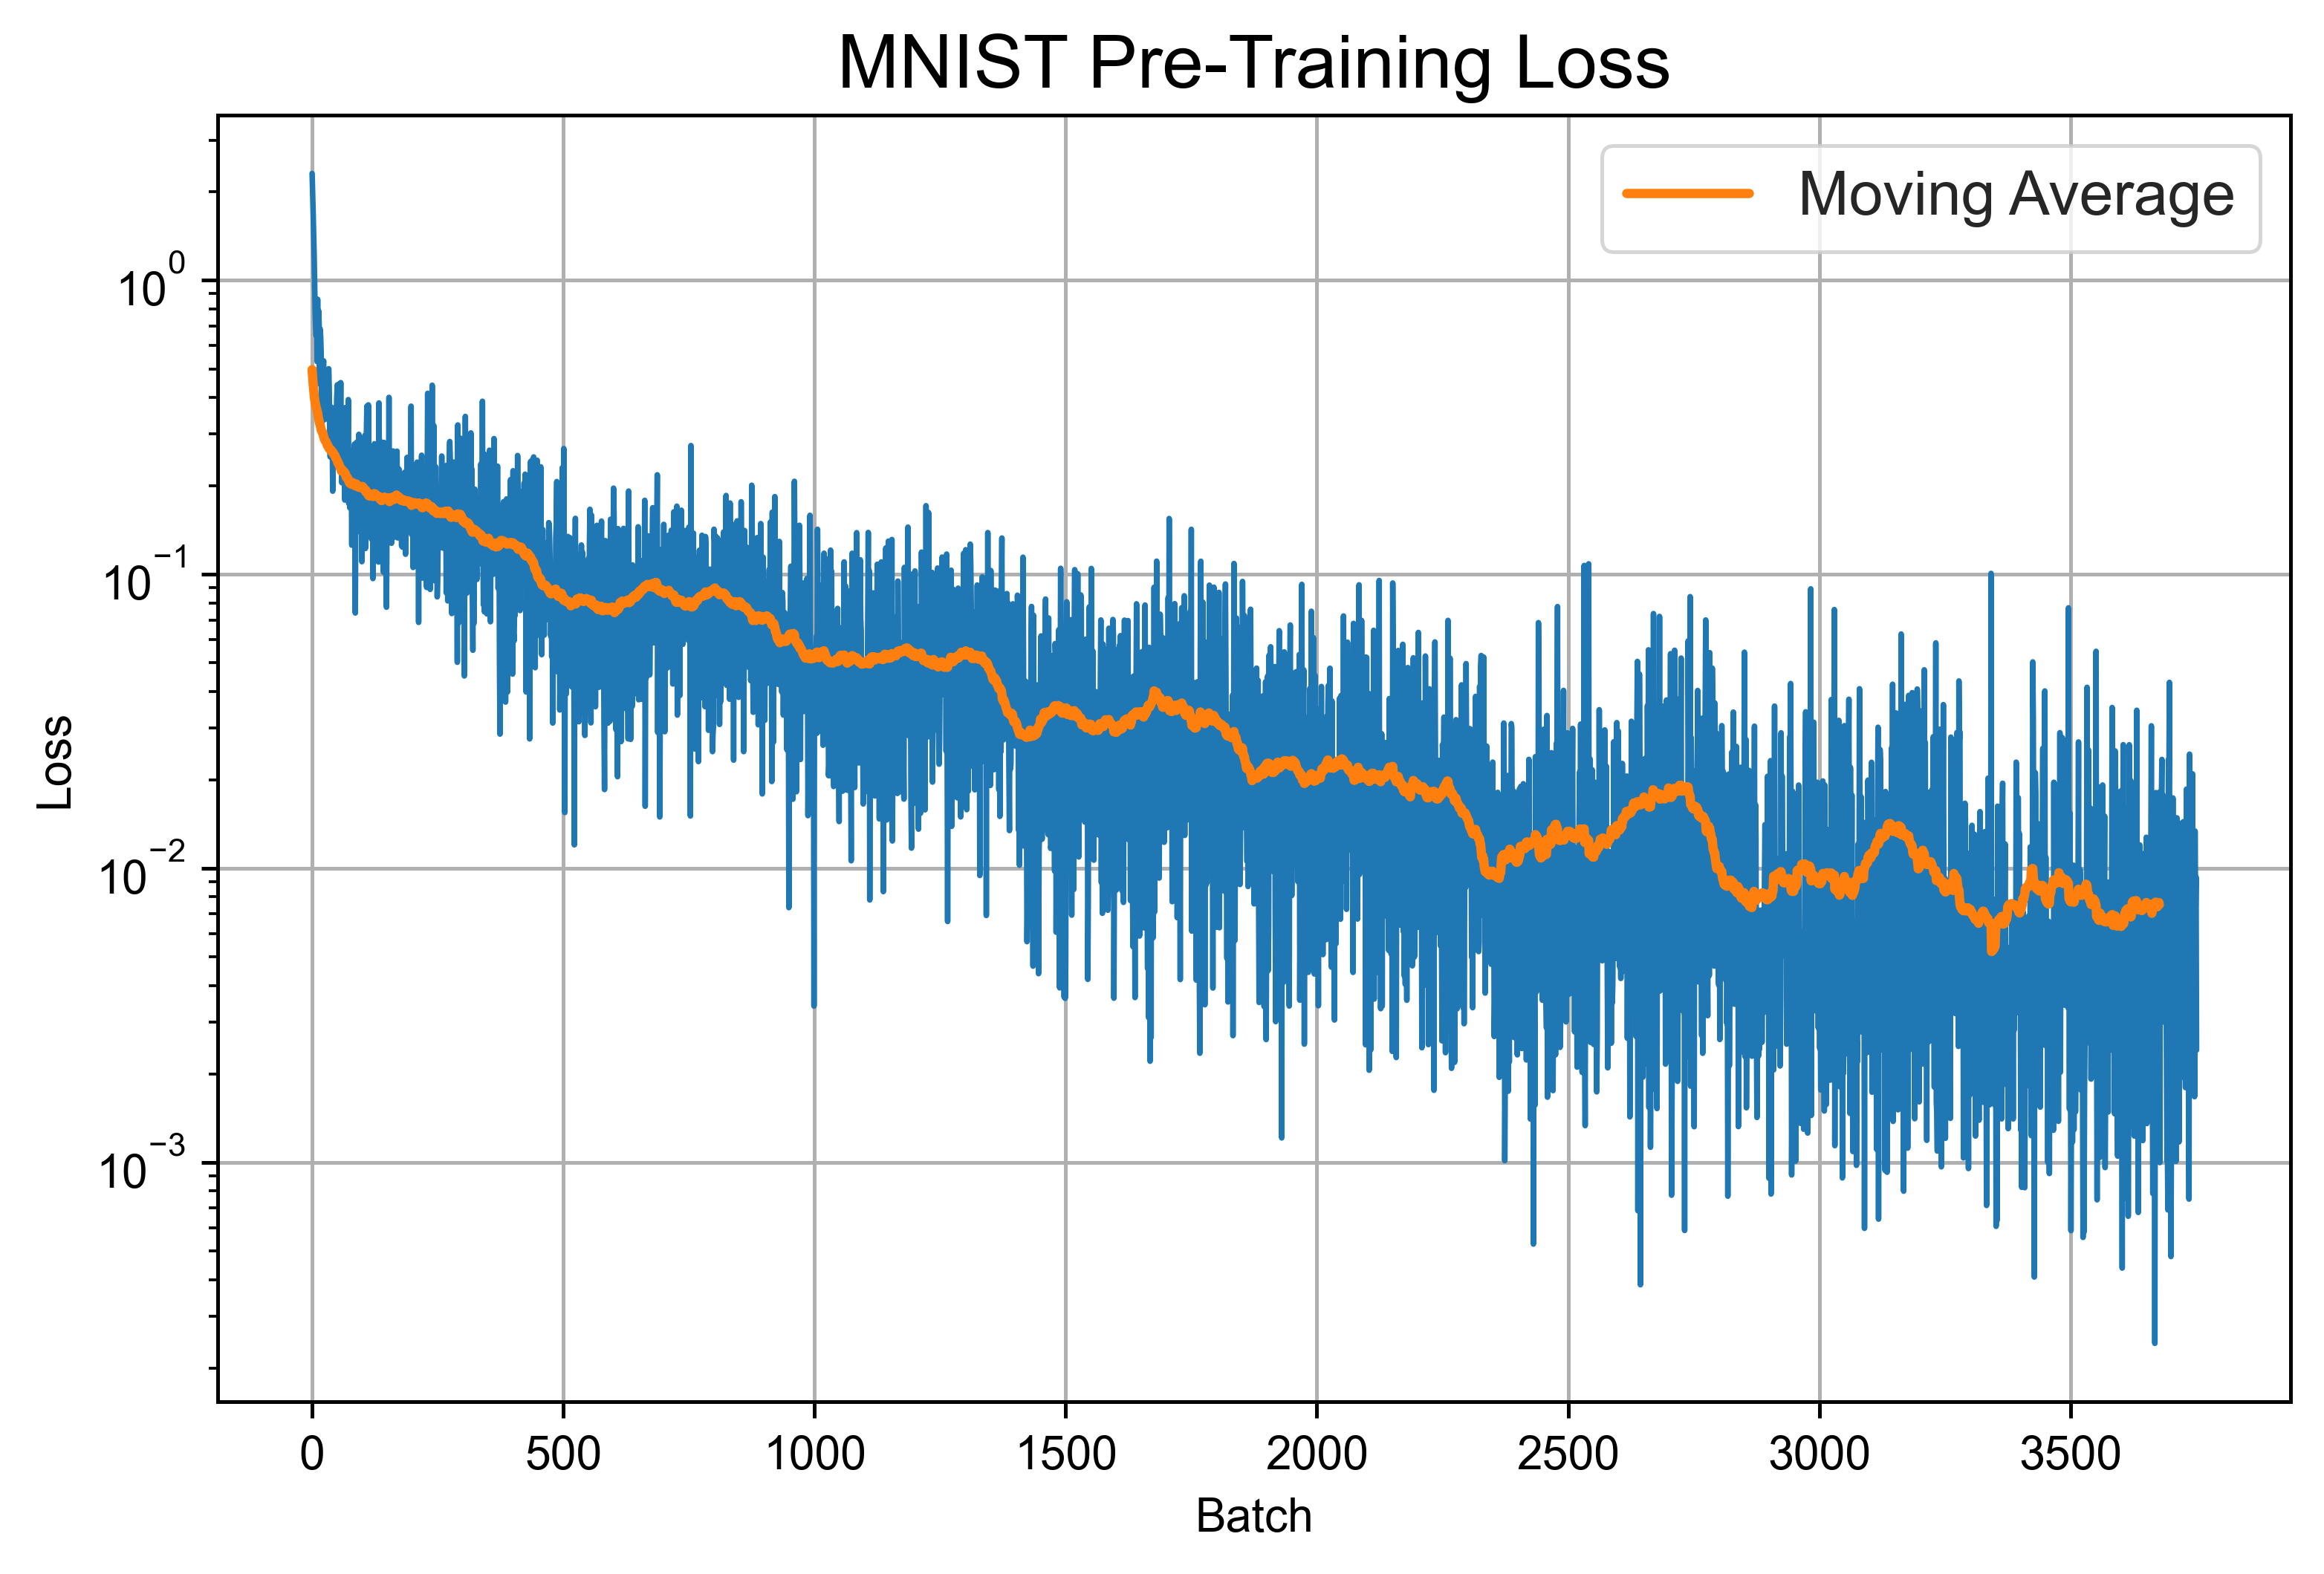

In [139]:
# Graph pt loss
chart_utils.initialize_plot_no_markers()
sns.lineplot(data=losses_pt)
# Plot the moving average of the losses
ma_width = 75
losses_pt_ma = np.convolve(losses_pt, np.ones(ma_width) / ma_width, mode="valid")
sns.lineplot(data=losses_pt_ma, label='Moving Average', linewidth=2)
plt.title("MNIST Pre-Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.yscale("log")
# plt.xscale("log")

plt.show()

## Prune the model to create unadaptable version

In [8]:
def apply_pruning_to_model(model, prune_percentage):
    """Pruning function: prune linear layers."""
    parameters_to_prune = (
        (layer, "weight")
        for layer in model.layers if isinstance(layer, nn.Linear)
    )

    for module, name in parameters_to_prune:
        prune.l1_unstructured(module, name, amount=prune_percentage)

prune_ratio = 0.85
print(f"Pruning the model by {prune_ratio}%...")
model_pruned_pt = copy.deepcopy(model_base_pt)
apply_pruning_to_model(model_pruned_pt, prune_percentage = prune_ratio)


Pruning the model by 0.85%...


Evaluating the pruned model on MNIST...

Test set: Average loss: 0.2929, Accuracy: 9720/10000 (97%)

model_base_pt accuracy: 0.9863, model_pruned_pt accuracy: 0.9720
model_base_pt loss: 0.0510, model_pruned_pt loss: 0.2929


C:\Users\Gabe\AppData\Local\Temp\ipykernel_15852\2949628677.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Base", "Pruned"], y=[mnist_accuracy_base_pt, mnist_accuracy_pruned_pt], palette="colorblind")


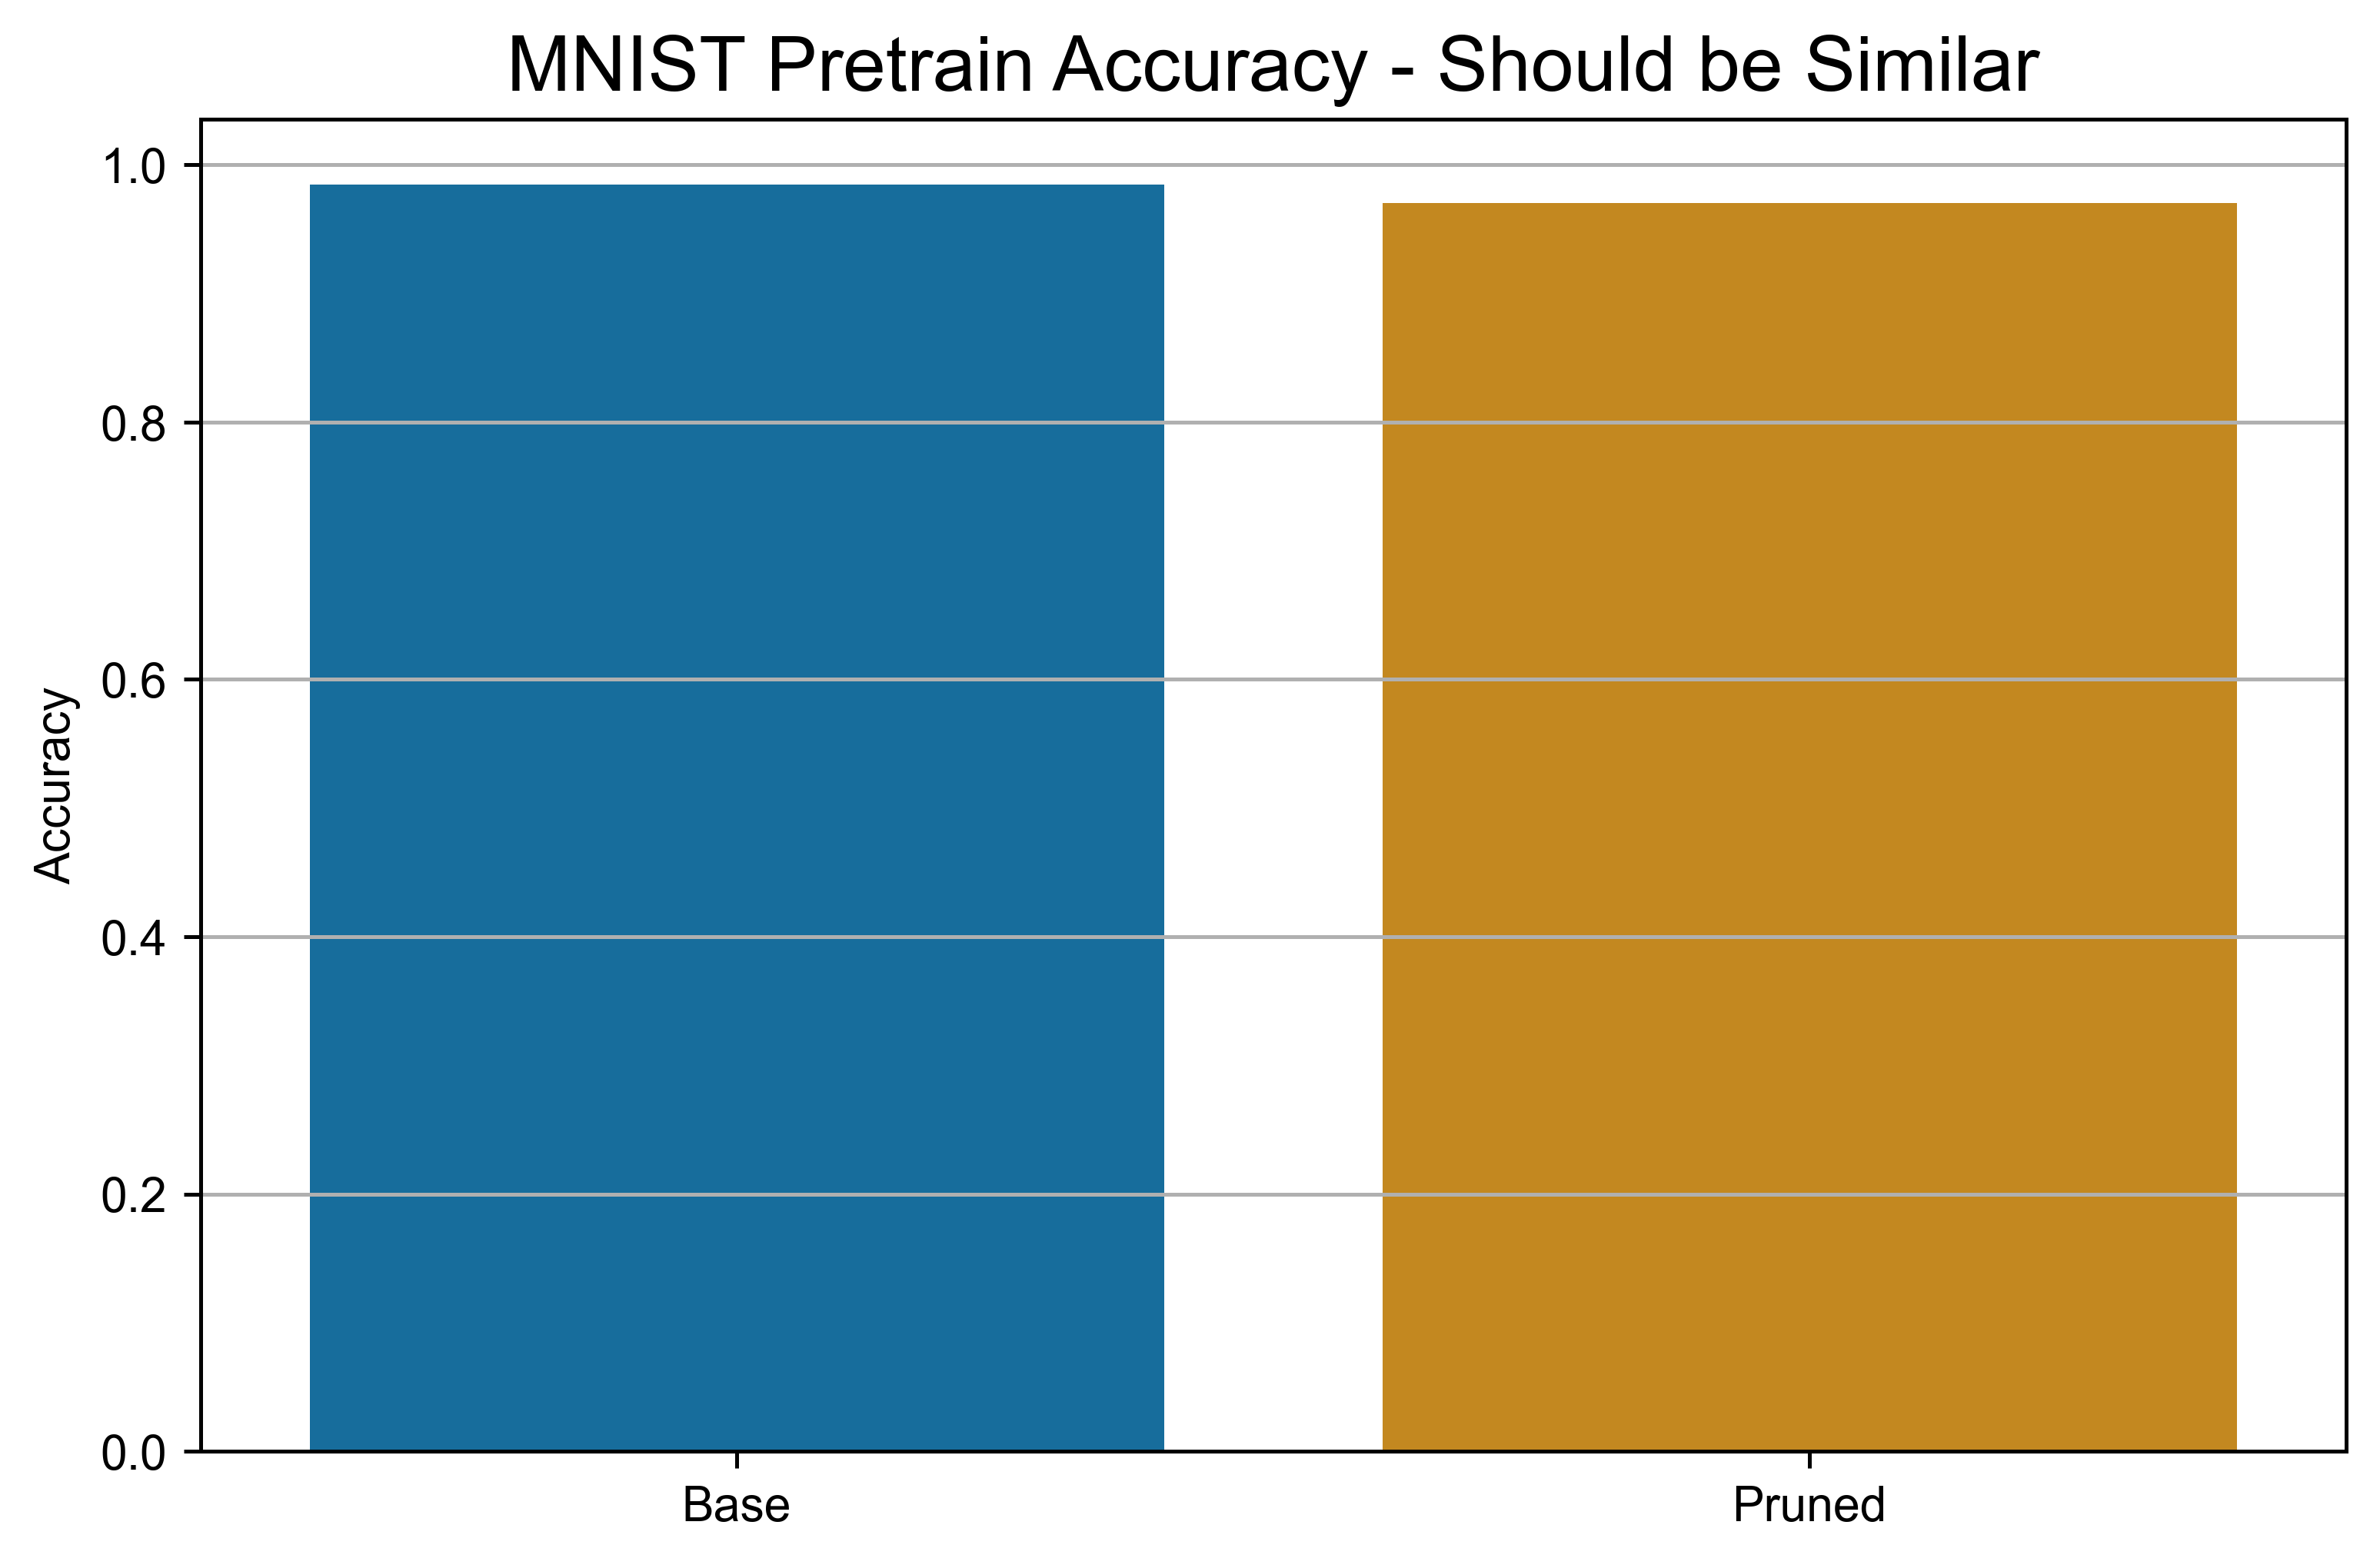

In [9]:
# Evaluate on MNIST test set
print("Evaluating the pruned model on MNIST...")
mnist_loss_pruned_pt, mnist_accuracy_pruned_pt = test(model_pruned_pt, device, mnist_test_loader)
print(f"model_base_pt accuracy: {mnist_accuracy_base_pt:.4f}, model_pruned_pt accuracy: {mnist_accuracy_pruned_pt:.4f}")
print(f"model_base_pt loss: {mnist_loss_base_pt:.4f}, model_pruned_pt loss: {mnist_loss_pruned_pt:.4f}")

# Bar chart comparing accuracies
chart_utils.initialize_plot_no_markers()
sns.barplot(x=["Base", "Pruned"], y=[mnist_accuracy_base_pt, mnist_accuracy_pruned_pt], palette="colorblind")
plt.title("MNIST Pretrain Accuracy - Should be Similar")
plt.ylabel("Accuracy")
plt.show()

## Fine-tune both the original and the pruned models on Fashion-MNIST

In [10]:
model_base_ft = copy.deepcopy(model_base_pt)
model_pruned_ft = copy.deepcopy(model_pruned_pt)

# Evaluate the pre-trained model on Fashion-MNIST
print("Evaluating the pre-trained model on Fashion-MNIST")
ft_loss_base_pt, ft_acc_base_pt = test(model_base_pt, device, fashion_test_loader)
ft_loss_pruned_pt, ft_acc_pruned_pt = test(model_pruned_pt, device, fashion_test_loader)
print(f"model_base_pt accuracy: {ft_acc_base_pt:.4f}, model_pruned_pt accuracy: {ft_acc_pruned_pt:.4f}")
print(f"model_base_pt loss: {ft_loss_base_pt:.4f}, model_pruned_pt loss: {ft_loss_pruned_pt:.4f}")

# Train the models on Fashion-MNIST
print("Training the base model on Fashion-MNIST")
losses_base_ft = train(model_base_ft, device, fashion_train_loader, num_epochs=ft_epochs)

print("Training the pruned model on Fashion-MNIST")
losses_pruned_ft = train(model_pruned_ft, device, fashion_train_loader, num_epochs=ft_epochs)

# Calculate metrics
ft_loss_base_ft, ft_acc_base_ft = test(model_base_ft, device, fashion_test_loader)
ft_loss_pruned_ft, ft_acc_pruned_ft = test(model_pruned_ft, device, fashion_test_loader)

print("Evaluating the fine-tuned models on Fashion-MNIST")
print(f"model_base_ft accuracy: {ft_acc_base_ft:.4f}, model_pruned_ft accuracy: {ft_acc_pruned_ft:.4f}")
print(f"model_base_ft loss: {ft_loss_base_ft:.4f}, model_pruned_ft loss: {ft_loss_pruned_ft:.4f}")

# loss_gap_ratio = abs(fine_tune_accuracy_base - fine_tune_accuracy_pruned)



Evaluating the pre-trained model on Fashion-MNIST

Test set: Average loss: 9.8019, Accuracy: 645/10000 (6%)


Test set: Average loss: 3.1267, Accuracy: 650/10000 (6%)

model_base_pt accuracy: 0.0645, model_pruned_pt accuracy: 0.0650
model_base_pt loss: 9.8019, model_pruned_pt loss: 3.1267
Training the base model on Fashion-MNIST


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.525093
Training the pruned model on Fashion-MNIST


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.585357

Test set: Average loss: 0.3841, Accuracy: 8636/10000 (86%)


Test set: Average loss: 0.4110, Accuracy: 8533/10000 (85%)

Evaluating the fine-tuned models on Fashion-MNIST
model_base_ft accuracy: 0.8636, model_pruned_ft accuracy: 0.8533
model_base_ft loss: 0.3841, model_pruned_ft loss: 0.4110


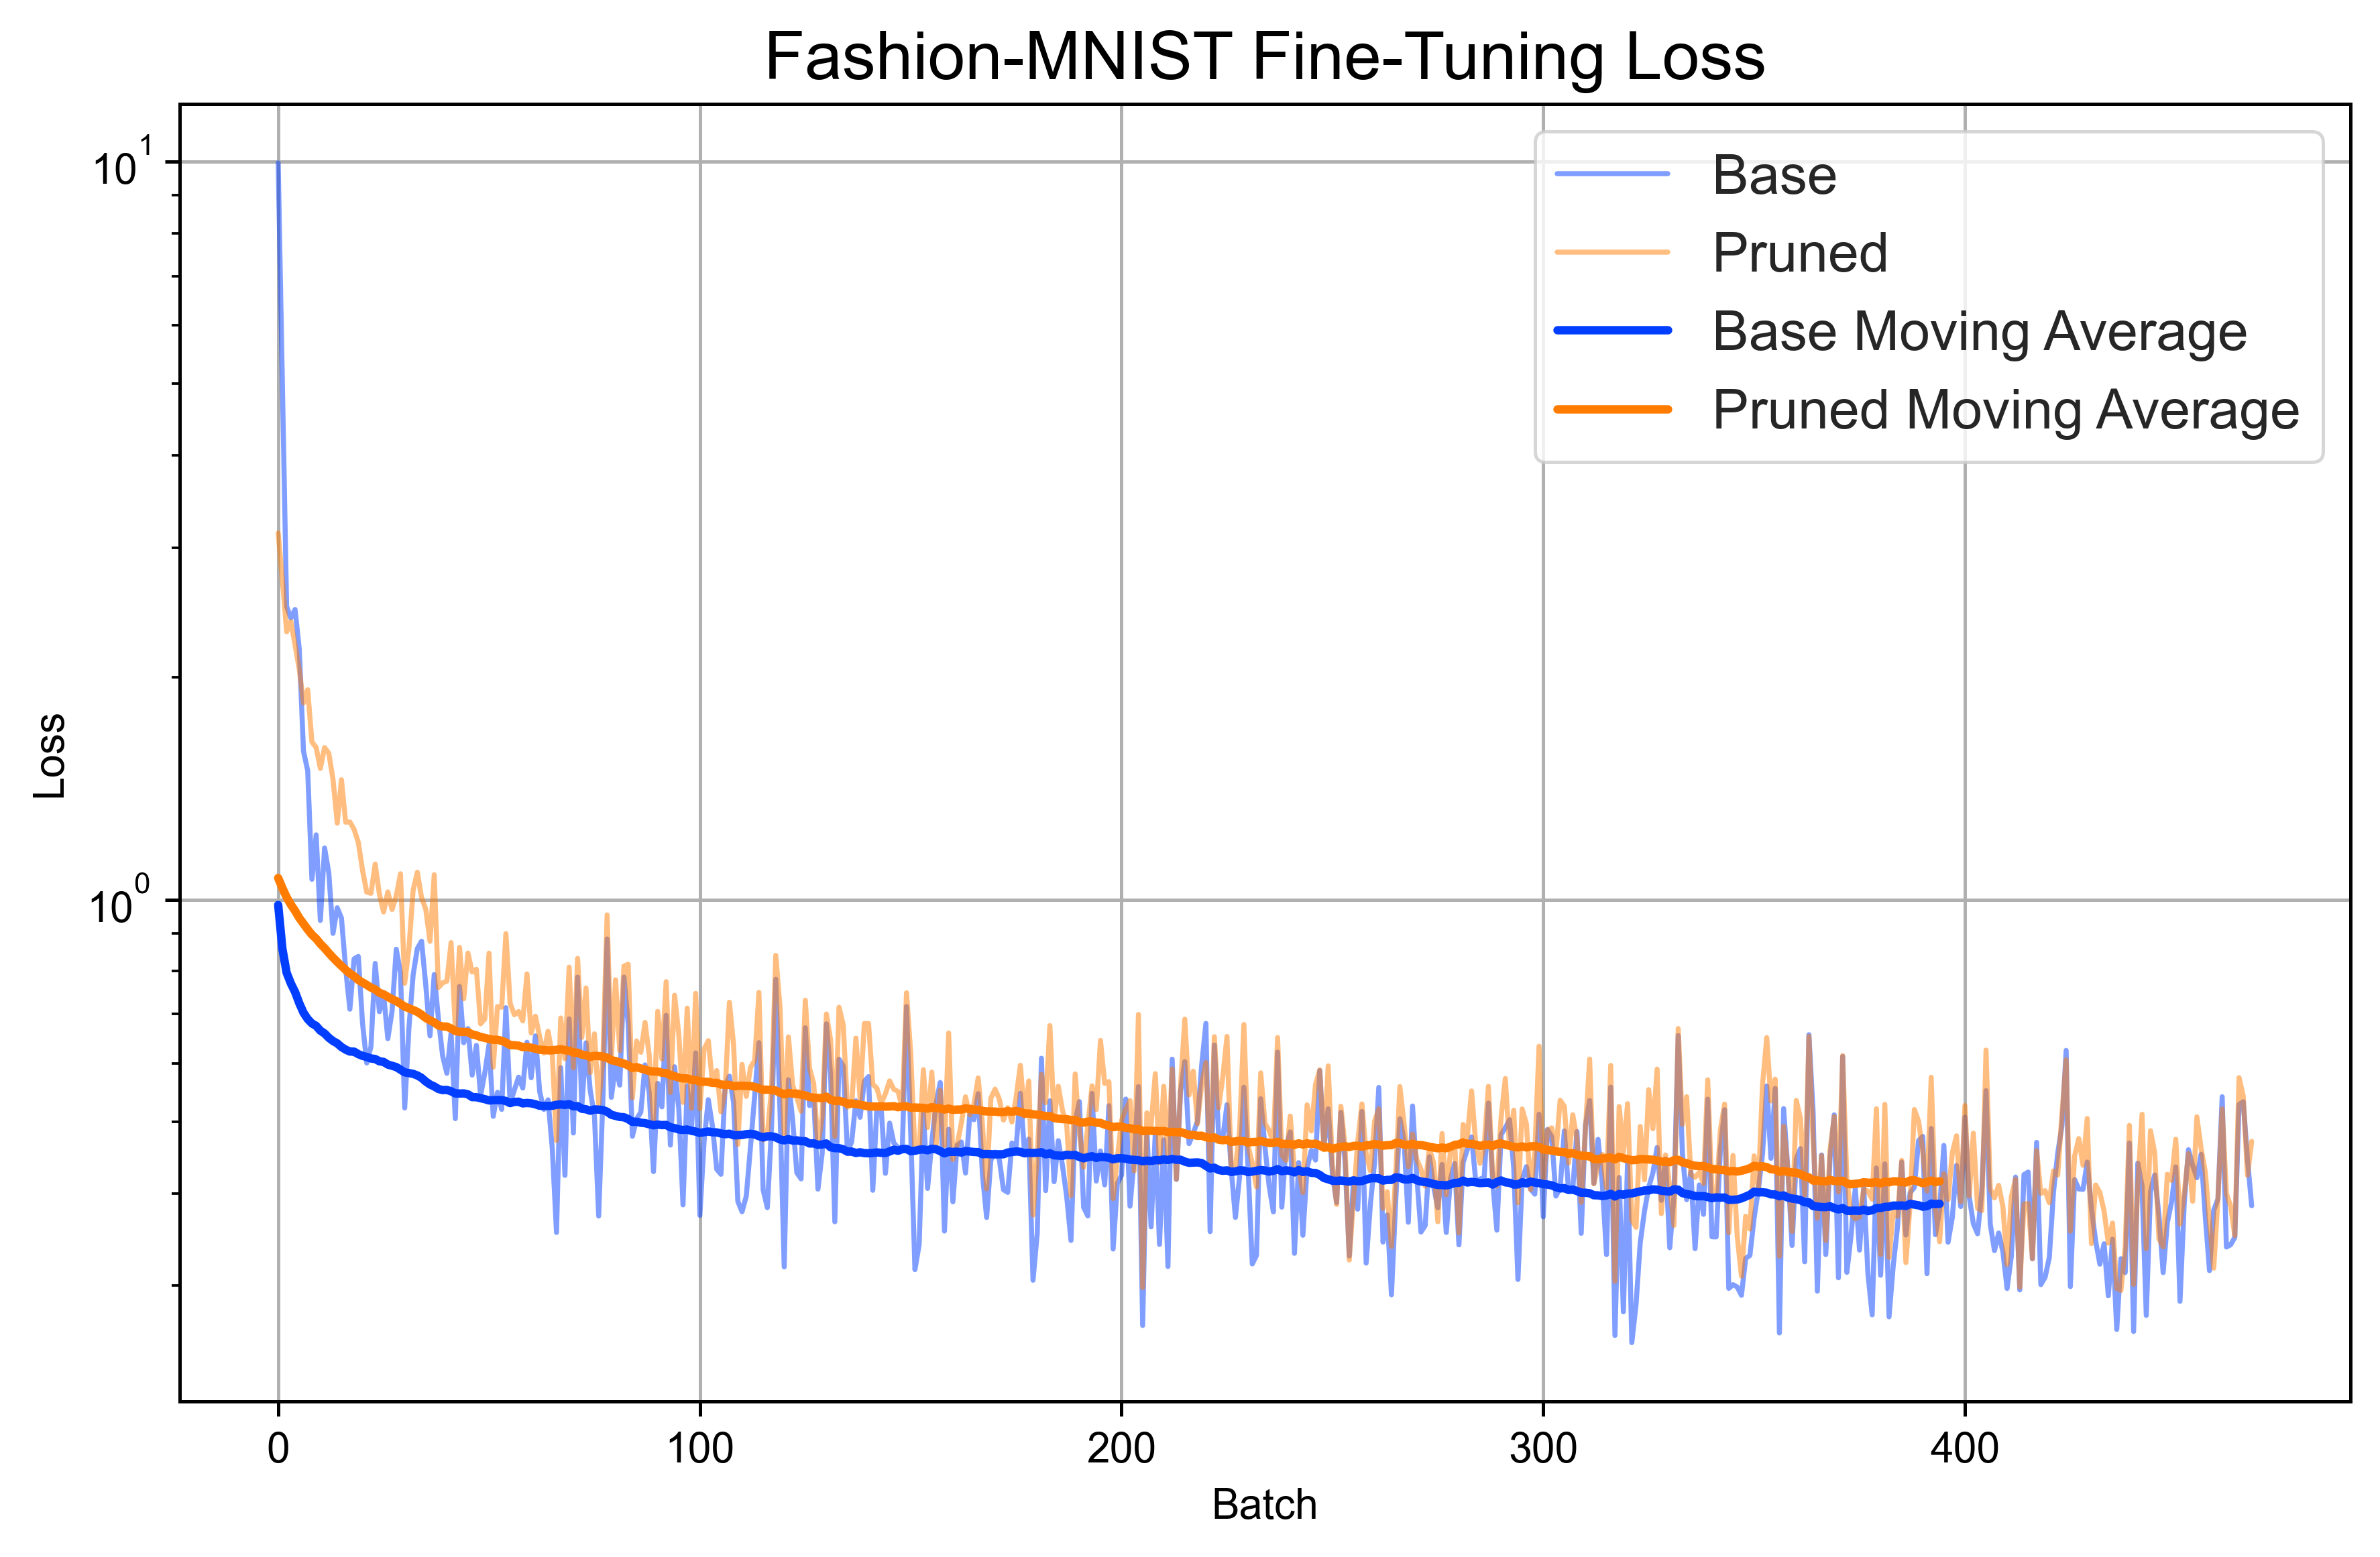

In [141]:
# Graph the ft losses togehter
chart_utils.initialize_plot_no_markers()
color_base = chart_utils.get_color_from_palette(0)
color_pruned = chart_utils.get_color_from_palette(1)
sns.lineplot(data=losses_base_ft, label="Base", color=color_base, alpha=0.5)
sns.lineplot(data=losses_pruned_ft, label="Pruned", color=color_pruned, alpha=0.5)
# Plot moving average
ma_width = 75
losses_base_ft_ma = np.convolve(losses_base_ft, np.ones(ma_width) / ma_width, mode="valid")
losses_pruned_ft_ma = np.convolve(losses_pruned_ft, np.ones(ma_width) / ma_width, mode="valid")
sns.lineplot(data=losses_base_ft_ma, label="Base Moving Average", color=color_base, linewidth=2)
sns.lineplot(data=losses_pruned_ft_ma, label="Pruned Moving Average", color=color_pruned, linewidth=2)

plt.title("Fashion-MNIST Fine-Tuning Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.yscale("log")
# plt.xscale("log")
plt.show()

In [12]:
def calculate_loss_gap_ratio(losses_unadapt, losses_base):
    loss_max = losses_base[0]  # Maximum loss, since you could always use the base model for the fine-tune task zero-shot
    # Min the losses_base with loss_max so it doesn't overcount from getting higher loss than the base_pt model
    losses_unadapt_clamped = np.minimum(loss_max, np.array(losses_unadapt, dtype=np.float32))
    # Gap between the "unadaptable" model and the base model
    loss_gap_ulm_alm = np.trapz(losses_unadapt_clamped - np.array(losses_base, dtype=np.float32))
    # Gap between the base model and the maximum loss
    loss_gap_max_alm = np.trapz(loss_max - np.array(losses_base, dtype=np.float32))
    # Ratio of the two gaps -- 100% means the unadaptable model is as bad as if you didn't do any fine-tuning
    loss_gap_ratio = loss_gap_ulm_alm / loss_gap_max_alm
    return loss_gap_ratio


loss_gap_ratio = calculate_loss_gap_ratio(losses_pruned_ft, losses_base_ft)
print(f"loss_gap_ratio: {loss_gap_ratio * 100:.4f}%")

loss_gap_ratio: 0.7157%


In [13]:
# Print the results
print(f"MNIST Test Accuracy (Base Pretrained): {mnist_accuracy_base_pt:.4f}")
print(f"MNIST Test Accuracy (Pruned Pretrained): {mnist_accuracy_pruned_pt:.4f}")
print(f"Fashion-MNIST Test Accuracy (Base Pretrained): {ft_acc_base_pt:.4f}")
print(f"Fashion-MNIST Test Accuracy (Pruned Pretrained): {ft_acc_pruned_pt:.4f}")
print(f"Fashion-MNIST Test Accuracy (Base Fine-Tuned): {ft_acc_base_ft:.4f}")
print(f"Fashion-MNIST Test Accuracy (Pruned Fine-Tuned): {ft_acc_pruned_ft:.4f}")
print(f"Loss Gap Ratio: {loss_gap_ratio * 100:.4f}%")

MNIST Test Accuracy (Base Pretrained): 0.9863
MNIST Test Accuracy (Pruned Pretrained): 0.9720
Fashion-MNIST Test Accuracy (Base Pretrained): 0.0645
Fashion-MNIST Test Accuracy (Pruned Pretrained): 0.0650
Fashion-MNIST Test Accuracy (Base Fine-Tuned): 0.8636
Fashion-MNIST Test Accuracy (Pruned Fine-Tuned): 0.8533
Loss Gap Ratio: 0.7157%


## Hyperparameter Sweep for Pruning



In [14]:
def calculate_unadaptability_metrics(unadaptation_method: callable):
    """Helper to calculate relative pretrain accuracy and loss gap ratio for a given unadaptation method."""
    # Make the model unadaptable
    model_pruned_pt = copy.deepcopy(model_base_pt)
    unadaptation_method(model_pruned_pt)
    
    # Calculate MNIST relative accuracy to the base mode
    _, mnist_accuracy_pruned_pt = test(model_pruned_pt, device, mnist_test_loader)
    mnist_accuracy_relative = mnist_accuracy_pruned_pt / mnist_accuracy_base_pt

    # Train the pruned model on Fashion-MNIST
    model_pruned_ft = copy.deepcopy(model_pruned_pt)
    losses_pruned_ft = train(model_pruned_ft, device, fashion_train_loader, num_epochs=ft_epochs)

    # Calculate the loss gap ratio
    loss_gap_ratio = calculate_loss_gap_ratio(losses_pruned_ft, losses_base_ft)

    # Return the results
    return mnist_accuracy_relative, loss_gap_ratio


unadaptability_results_pruning: tuple[float, float, float] = [] # (prune_ratio, mnist_accuracy_relative, loss_gap_ratio)
for prune_ratio in [0.0, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97]:
    # Prune a new model from the pretrained model
    print(f"Pruning {prune_ratio * 100:.0f}% of the model")
    def unadapt(model):
        apply_pruning_to_model(model, prune_percentage=prune_ratio)
    mnist_accuracy_relative, loss_gap_ratio = calculate_unadaptability_metrics(unadapt)
    print(f"Relative Pretrain Accuracy: {mnist_accuracy_relative:.4f} - Loss Gap Ratio: {loss_gap_ratio * 100:.4f}%\n")
    unadaptability_results_pruning.append((prune_ratio, mnist_accuracy_relative, loss_gap_ratio))
    

Pruning 0% of the model

Test set: Average loss: 0.0510, Accuracy: 9863/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.528322
Relative Pretrain Accuracy: 1.0000 - Loss Gap Ratio: 0.0335%

Pruning 50% of the model

Test set: Average loss: 0.0457, Accuracy: 9866/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.548517
Relative Pretrain Accuracy: 1.0003 - Loss Gap Ratio: 0.2722%

Pruning 70% of the model

Test set: Average loss: 0.0598, Accuracy: 9855/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.553689
Relative Pretrain Accuracy: 0.9992 - Loss Gap Ratio: 0.3587%

Pruning 75% of the model

Test set: Average loss: 0.0812, Accuracy: 9836/10000 (98%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.558051
Relative Pretrain Accuracy: 0.9973 - Loss Gap Ratio: 0.4148%

Pruning 80% of the model

Test set: Average loss: 0.1388, Accuracy: 9776/10000 (98%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.570908
Relative Pretrain Accuracy: 0.9912 - Loss Gap Ratio: 0.5552%

Pruning 85% of the model

Test set: Average loss: 0.2929, Accuracy: 9720/10000 (97%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.587231
Relative Pretrain Accuracy: 0.9855 - Loss Gap Ratio: 0.7350%

Pruning 90% of the model

Test set: Average loss: 0.7716, Accuracy: 9544/10000 (95%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.626645
Relative Pretrain Accuracy: 0.9677 - Loss Gap Ratio: 1.1582%

Pruning 91% of the model

Test set: Average loss: 0.9384, Accuracy: 9459/10000 (95%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.642206
Relative Pretrain Accuracy: 0.9590 - Loss Gap Ratio: 1.3234%

Pruning 92% of the model

Test set: Average loss: 1.1046, Accuracy: 9327/10000 (93%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.658050
Relative Pretrain Accuracy: 0.9457 - Loss Gap Ratio: 1.4927%

Pruning 93% of the model

Test set: Average loss: 1.3111, Accuracy: 9165/10000 (92%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.679286
Relative Pretrain Accuracy: 0.9292 - Loss Gap Ratio: 1.7189%

Pruning 94% of the model

Test set: Average loss: 1.5129, Accuracy: 8846/10000 (88%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.708476
Relative Pretrain Accuracy: 0.8969 - Loss Gap Ratio: 2.0290%

Pruning 95% of the model

Test set: Average loss: 1.7030, Accuracy: 8530/10000 (85%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.748783
Relative Pretrain Accuracy: 0.8648 - Loss Gap Ratio: 2.4561%

Pruning 96% of the model

Test set: Average loss: 1.8954, Accuracy: 8123/10000 (81%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.789930
Relative Pretrain Accuracy: 0.8236 - Loss Gap Ratio: 2.8940%

Pruning 97% of the model

Test set: Average loss: 2.0509, Accuracy: 6840/10000 (68%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.864739
Relative Pretrain Accuracy: 0.6935 - Loss Gap Ratio: 3.6873%



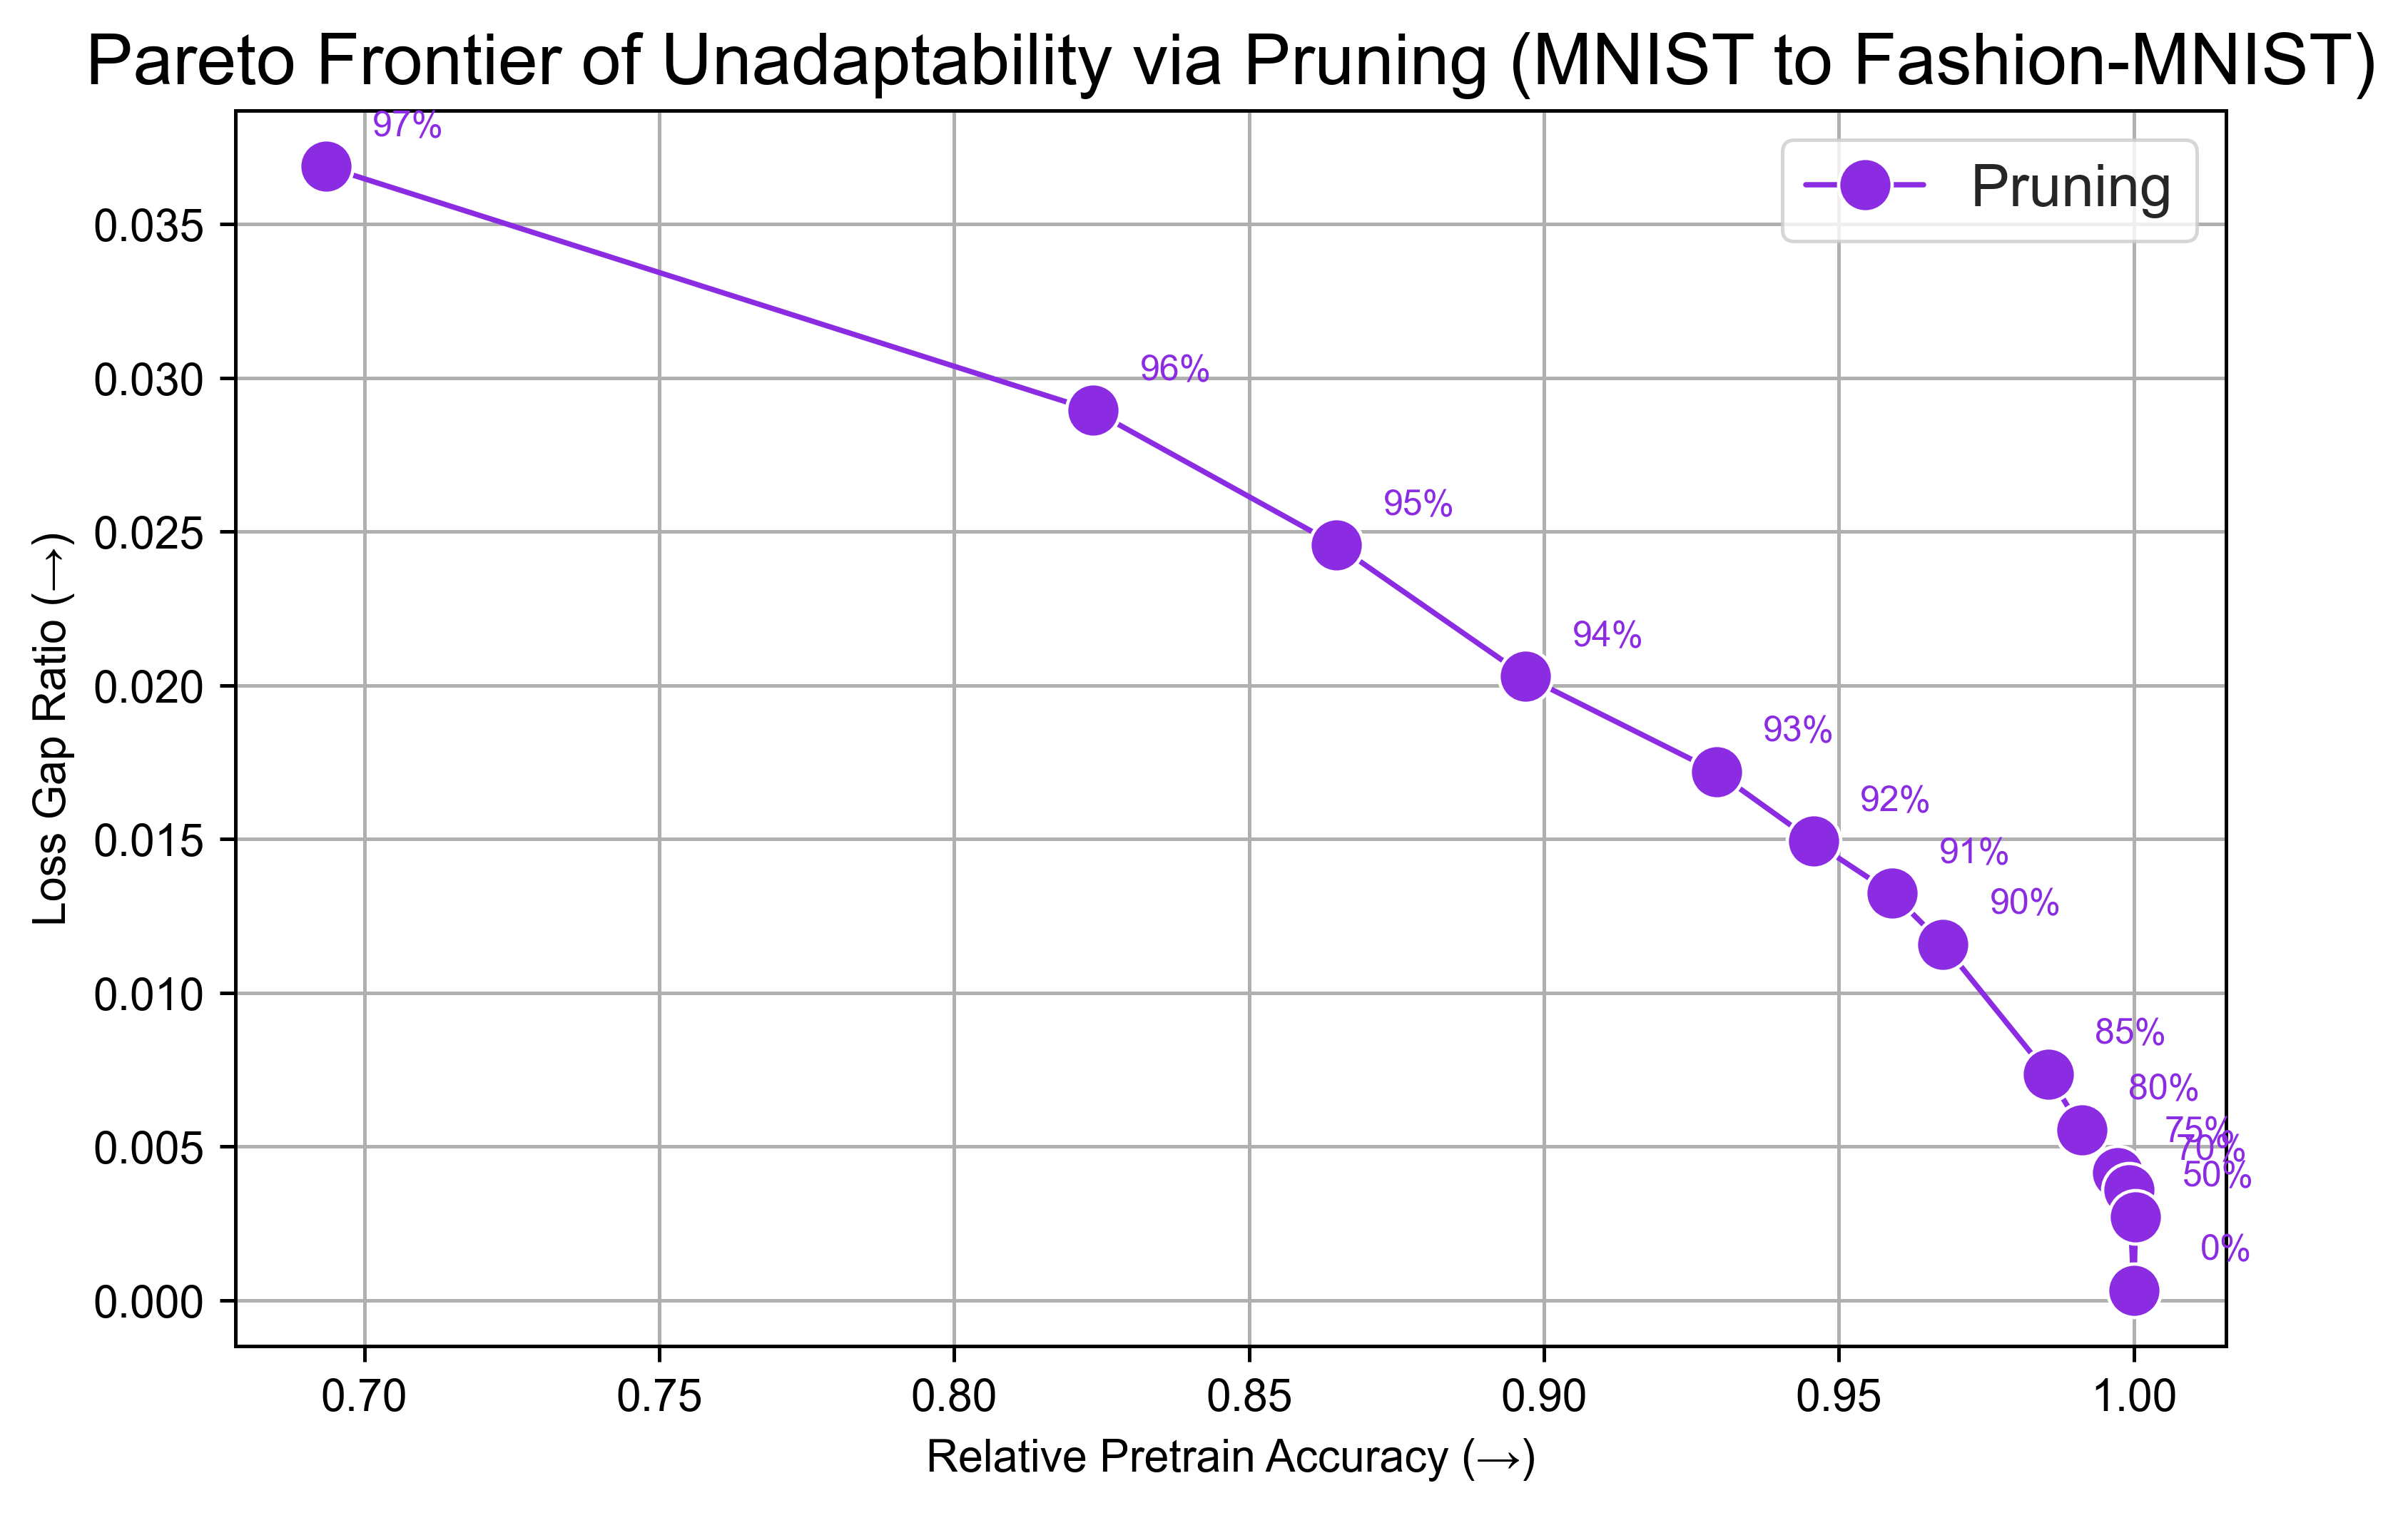

In [15]:
# Graph the pareto frontier
chart_utils.initialize_plot_default()
color = chart_utils.get_color_from_palette(4)
sns.lineplot(x=[x[1] for x in unadaptability_results_pruning], y=[x[2] for x in unadaptability_results_pruning], color=color, label="Pruning")
# Add labels
for prune_ratio, mnist_accuracy_relative, loss_gap_ratio in unadaptability_results_pruning:
    plt.text(mnist_accuracy_relative + 0.02, loss_gap_ratio + 0.001, f"{prune_ratio * 100:.0f}%", fontsize=8, ha="right", color=color)
plt.title("Pareto Frontier of Unadaptability via Pruning (MNIST to Fashion-MNIST)")
plt.xlabel("Relative Pretrain Accuracy (→)")
plt.ylabel("Loss Gap Ratio (→)")
plt.show()

## Weight Rescaling
So pruning doesn't work too well. Let's instead try multiplying each pair of weight matrices by $C$ and $1/C$ to mess with the gradients without changing the forward pass output. 

In [16]:
def apply_weight_rescaling_to_model(model, rescale_factor):
    """For each pair of linear linear, scale the first by C and the second by 1/C."""
    linear_layers = [layer for layer in model.layers if isinstance(layer, nn.Linear)]

    for i in range(0, len(linear_layers) - 1, 2):
        linear_layers[i].weight.data *= rescale_factor
        linear_layers[i + 1].weight.data /= rescale_factor

Rescaling the model by 1000.0x
Evaluating the pruned model on MNIST...

Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)

model_base_pt accuracy: 0.9863, model_rescaled_pt accuracy: 0.9864
model_base_pt loss: 0.0510, model_rescaled_pt loss: 0.2929
Relative Accuracy: 1.0001


C:\Users\Gabe\AppData\Local\Temp\ipykernel_15852\2985918157.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Base", "Rescaled"], y=[mnist_accuracy_base_pt, mnist_accuracy_rescaled_pt], palette="colorblind")


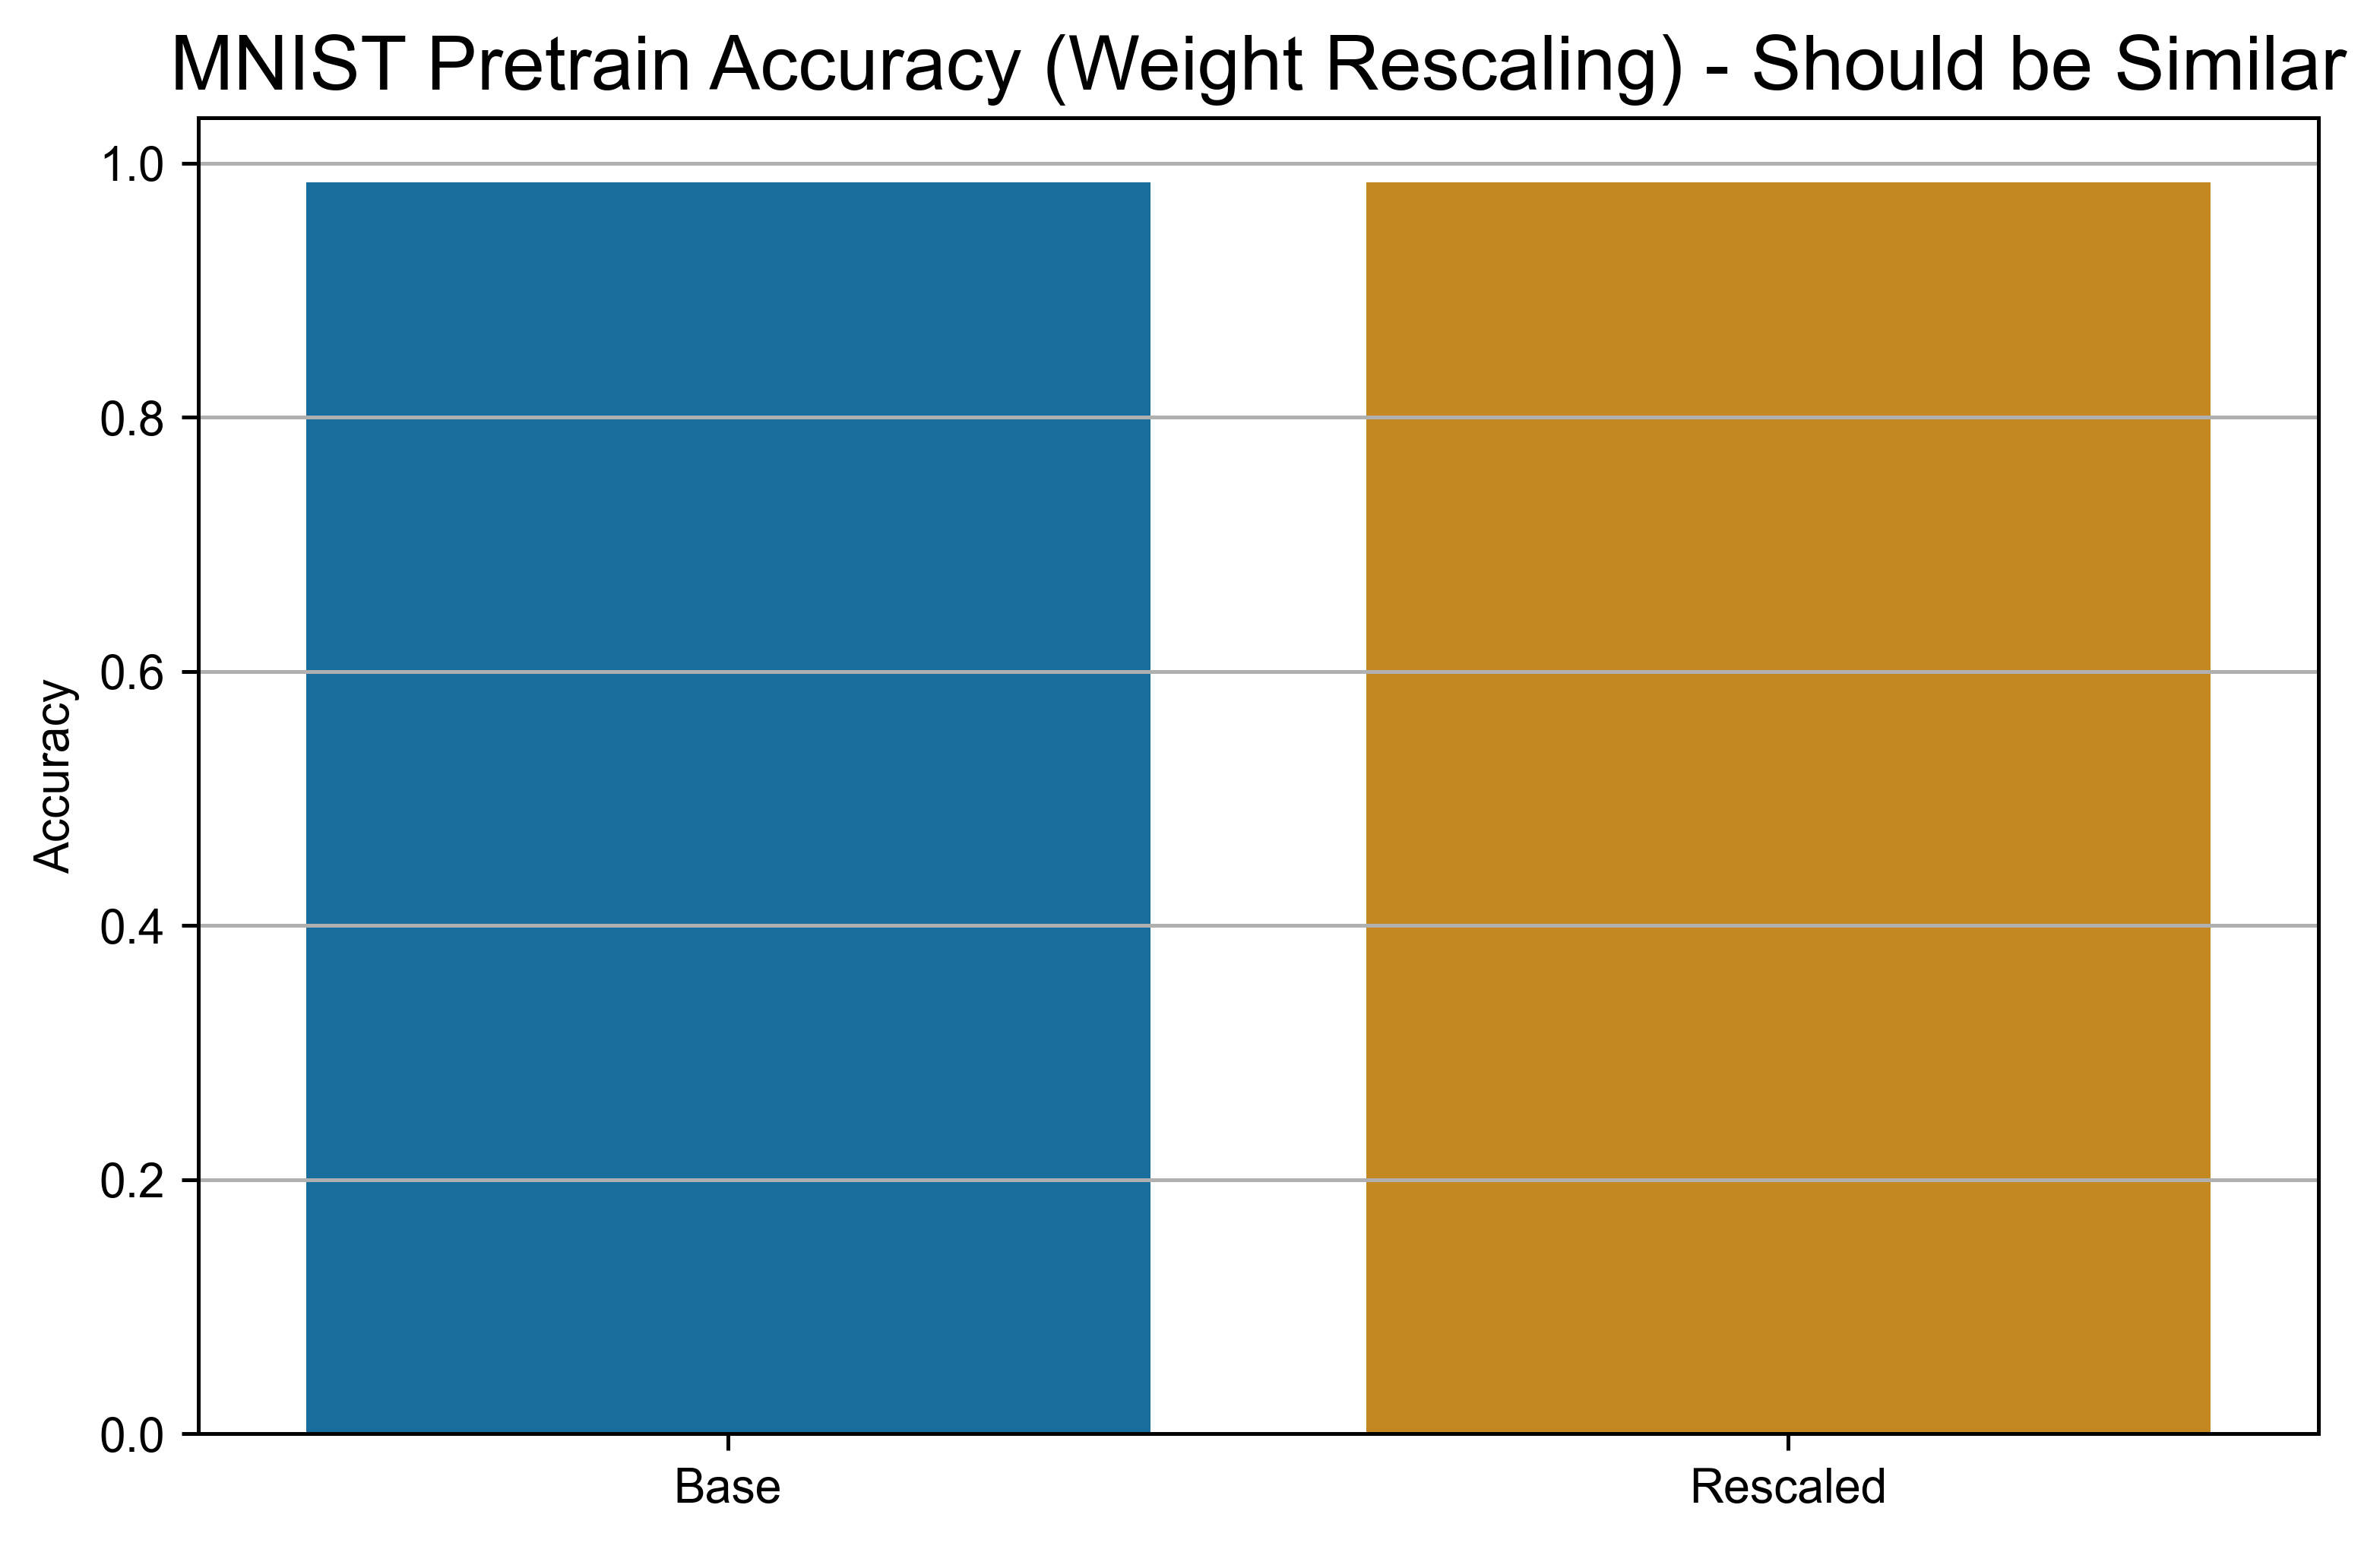

In [17]:
# Test weight rescaling
rescale_factor = 1e3
print(f"Rescaling the model by {rescale_factor}x")
model_rescaled_pt = copy.deepcopy(model_base_pt)
apply_weight_rescaling_to_model(model_rescaled_pt, rescale_factor = rescale_factor)

# Evaluate on MNIST test set
print("Evaluating the pruned model on MNIST...")
mnist_loss_rescaled_pt, mnist_accuracy_rescaled_pt = test(model_rescaled_pt, device, mnist_test_loader)
print(f"model_base_pt accuracy: {mnist_accuracy_base_pt:.4f}, model_rescaled_pt accuracy: {mnist_accuracy_rescaled_pt:.4f}")
print(f"model_base_pt loss: {mnist_loss_base_pt:.4f}, model_rescaled_pt loss: {mnist_loss_pruned_pt:.4f}")
reltive_accuracy = mnist_accuracy_rescaled_pt / mnist_accuracy_base_pt  # Should be close to 1
print(f"Relative Accuracy: {reltive_accuracy:.4f}")

# Bar chart comparing accuracies
chart_utils.initialize_plot_no_markers()
sns.barplot(x=["Base", "Rescaled"], y=[mnist_accuracy_base_pt, mnist_accuracy_rescaled_pt], palette="colorblind")
plt.title("MNIST Pretrain Accuracy (Weight Rescaling) - Should be Similar")
plt.ylabel("Accuracy")
plt.show()

In [170]:
# Run a sweep over the rescale factor
np.random.seed(seed)
torch.manual_seed(seed)
unadaptability_results_rescale: tuple[float, float, float] = [] # (rescale_factor, mnist_accuracy_relative, loss_gap_ratio)
all_rescale_factors = [3, 1e1, 3e1, 1e2, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7, 1e8, 3e8, 1e9]
for rescale_factor in all_rescale_factors:
    # Prune a new model from the pretrained model
    print(f"Rescaling the model by {rescale_factor:.0e} - ", end="")
    def unadapt(model):
        apply_weight_rescaling_to_model(model, rescale_factor)
    mnist_accuracy_relative, loss_gap_ratio = calculate_unadaptability_metrics(unadapt)
    print(f"Relative Pretrain Accuracy: {mnist_accuracy_relative:.4f} - Loss Gap Ratio: {loss_gap_ratio * 100:.4f}%\n")
    unadaptability_results_rescale.append((rescale_factor, mnist_accuracy_relative, loss_gap_ratio))


Rescaling the model by 3e+00 - 
Test set: Average loss: 0.0510, Accuracy: 9863/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.520416
Relative Pretrain Accuracy: 1.0000 - Loss Gap Ratio: -0.0483%

Rescaling the model by 1e+01 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.539957
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 0.1549%

Rescaling the model by 3e+01 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.645946
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 1.2816%

Rescaling the model by 1e+02 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 0.934892
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 4.0602%

Rescaling the model by 3e+02 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 1.883848
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 10.2639%

Rescaling the model by 1e+03 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 4.985674
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 19.7749%

Rescaling the model by 3e+03 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 14.861398
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 28.5540%

Rescaling the model by 1e+04 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 48.455118
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 38.9378%

Rescaling the model by 3e+04 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 165.905831
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 54.4032%

Rescaling the model by 1e+05 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 449.029792
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 62.2860%

Rescaling the model by 3e+05 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 1222.330499
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 78.0678%

Rescaling the model by 1e+06 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 4650.513818
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 88.8634%

Rescaling the model by 3e+06 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 12289.818821
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 95.5804%

Rescaling the model by 1e+07 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 47360.131366
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 97.5119%

Rescaling the model by 3e+07 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 124904.878820
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 99.5585%

Rescaling the model by 1e+08 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 463716.957773
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 99.2556%

Rescaling the model by 3e+08 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 1431004.505577
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 99.8118%

Rescaling the model by 1e+09 - 
Test set: Average loss: 0.0510, Accuracy: 9864/10000 (99%)



  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 4806906.922453
Relative Pretrain Accuracy: 1.0001 - Loss Gap Ratio: 99.8101%



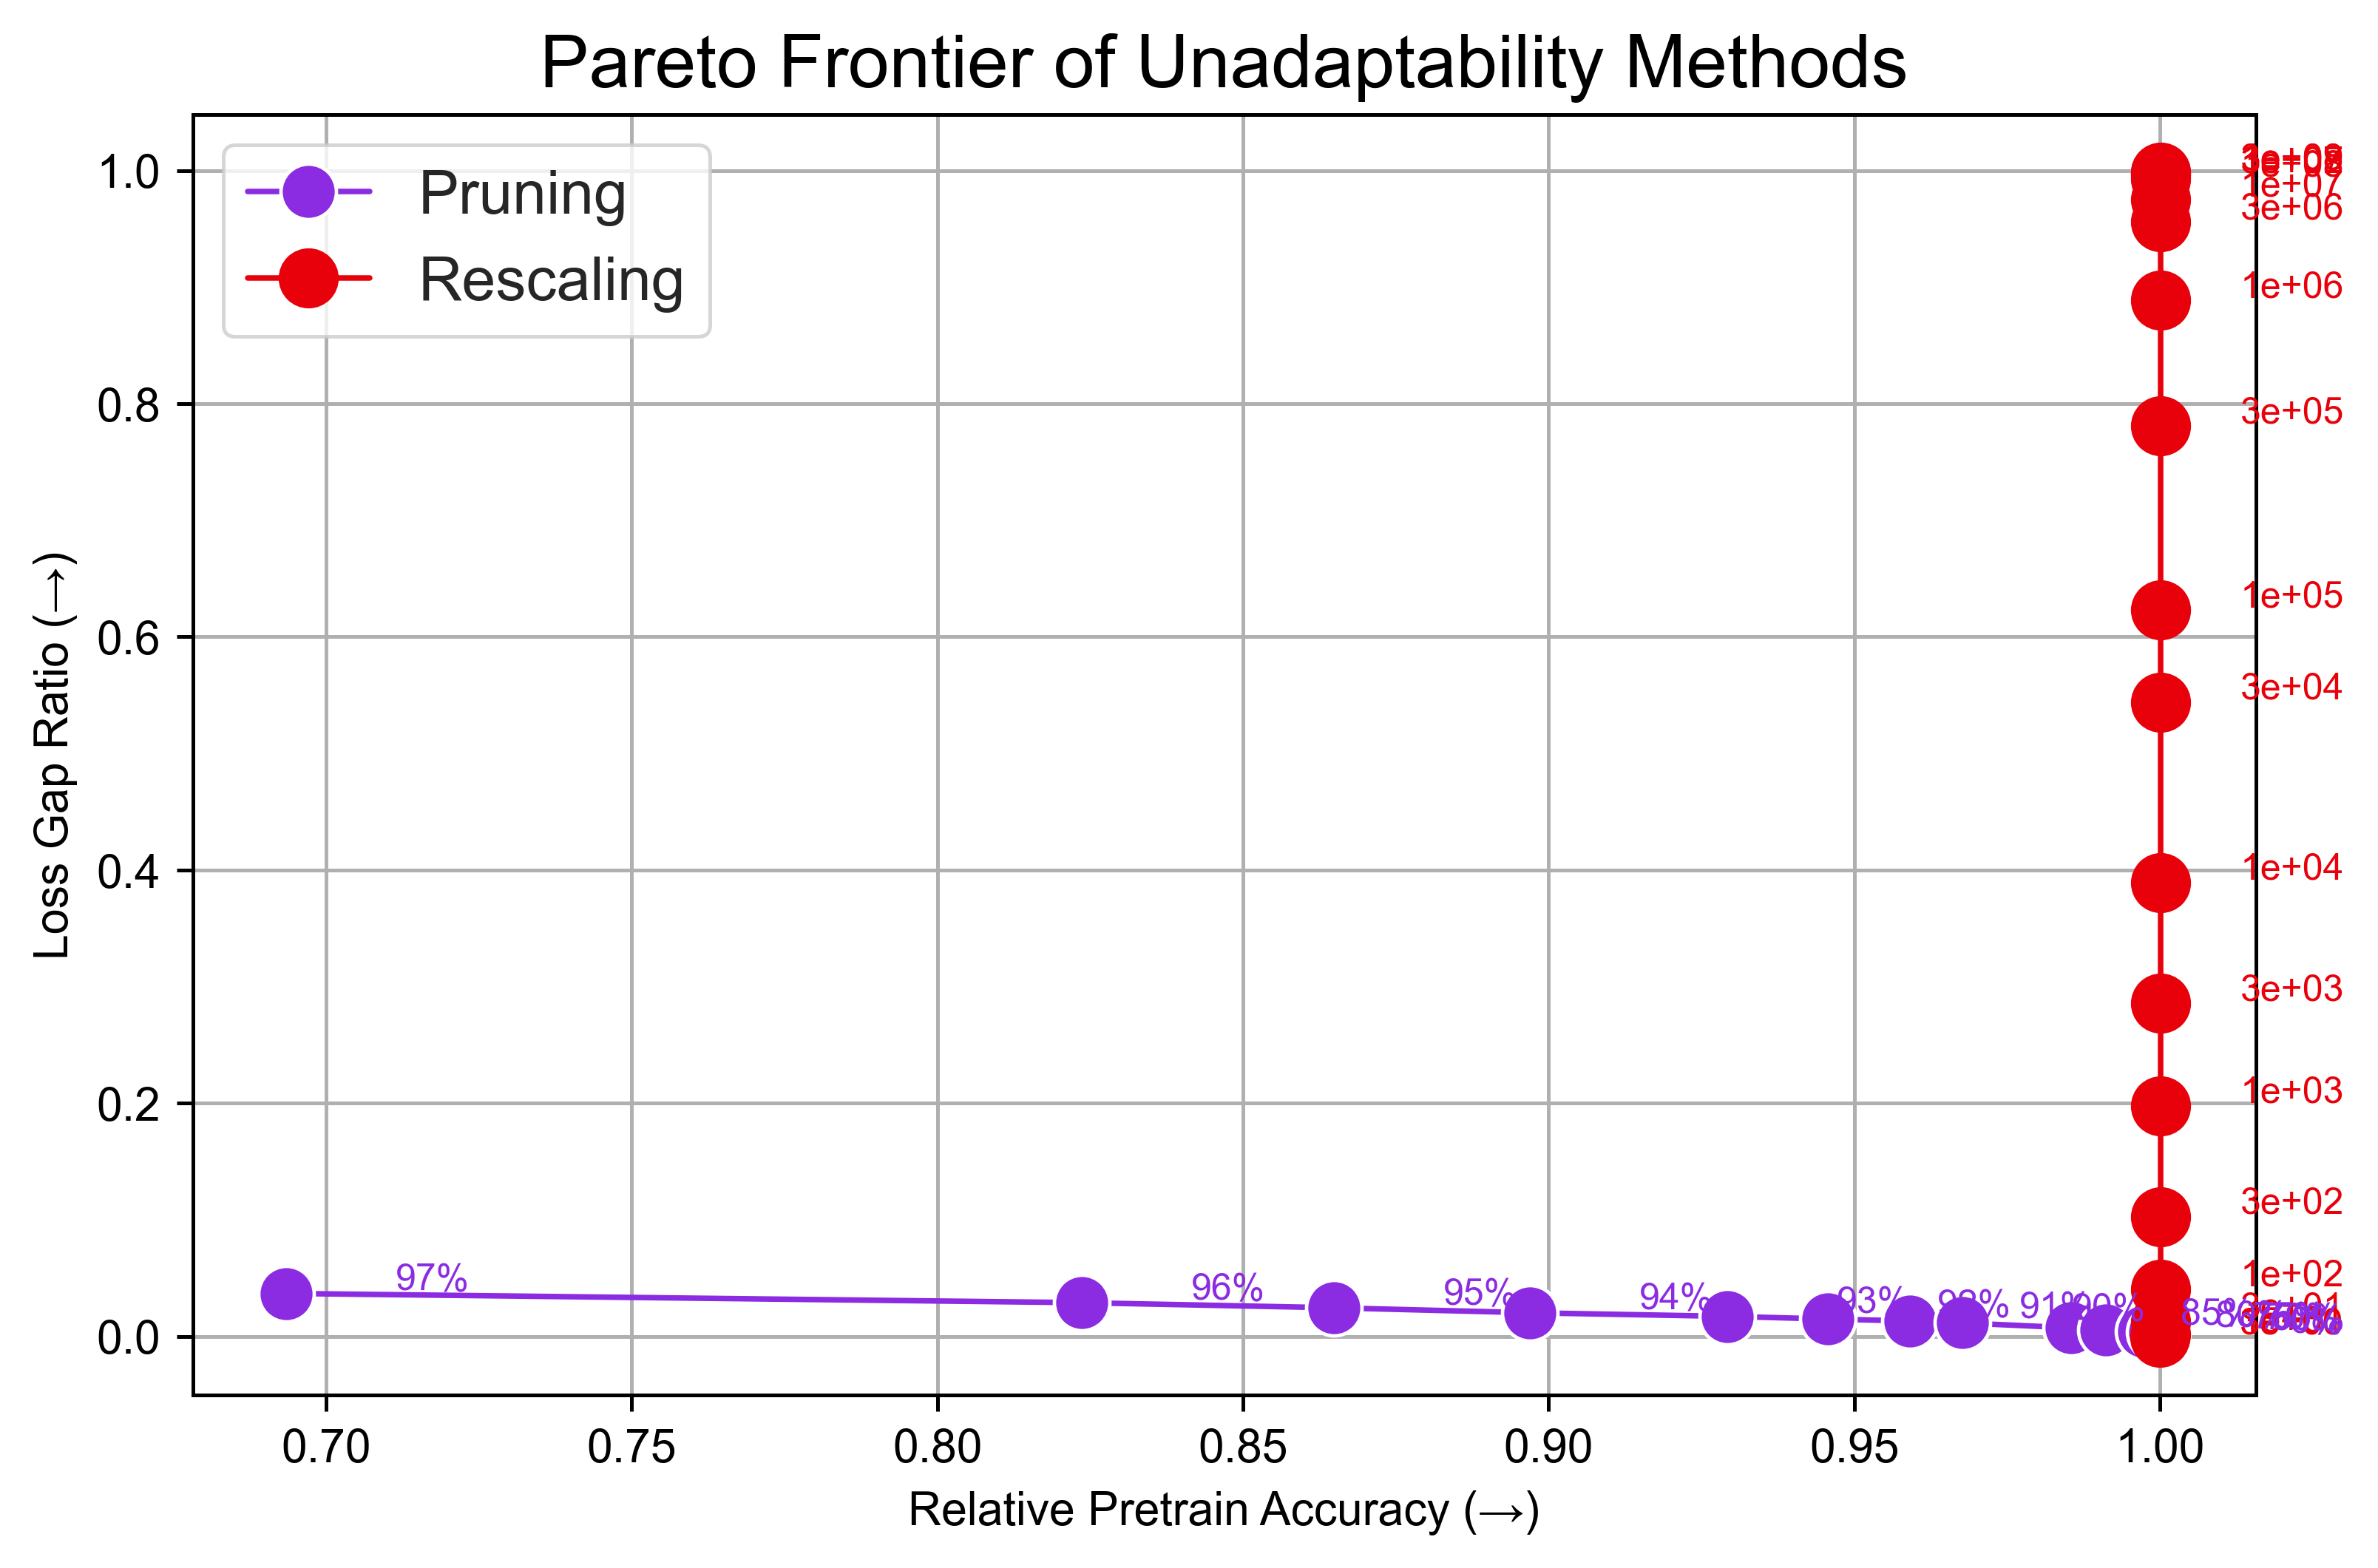

In [171]:
# Graph the pareto frontier with both pruning and rescaling
chart_utils.initialize_plot_default()
color_prune = chart_utils.get_color_from_palette(4)
color_rescale = chart_utils.get_color_from_palette(3)
sns.lineplot(x=[x[1] for x in unadaptability_results_pruning], y=[x[2] for x in unadaptability_results_pruning], color=color_prune, label="Pruning")
# sns.lineplot(x=[x[1] for x in unadaptability_results_rescale], y=[x[2] for x in unadaptability_results_rescale], color=color_rescale, label="Rescaling", sort=False, lw=1, markers=False)
# Matplotlib instead of seaborn so we can plot vertical lines
plt.plot([x[1] for x in unadaptability_results_rescale], [x[2] for x in unadaptability_results_rescale], color=color_rescale, label="Rescaling")
# Add labels
x_offset = 0.03
y_offset = 0.003
for rescale_factor, mnist_accuracy_relative, loss_gap_ratio in unadaptability_results_rescale:
    plt.text(mnist_accuracy_relative + x_offset, loss_gap_ratio + y_offset, f"{rescale_factor:.0e}", fontsize=8, ha="right", color=color_rescale)
for prune_ratio, mnist_accuracy_relative, loss_gap_ratio in unadaptability_results_pruning:
    plt.text(mnist_accuracy_relative + x_offset, loss_gap_ratio + y_offset, f"{prune_ratio * 100:.0f}%", fontsize=8, ha="right", color=color_prune)
plt.title("Pareto Frontier of Unadaptability Methods")
plt.xlabel("Relative Pretrain Accuracy (→)")
plt.ylabel("Loss Gap Ratio (→)")
plt.legend()
# plt.yscale("log")
# plt.ylim(0.01, 0.21)
plt.show()



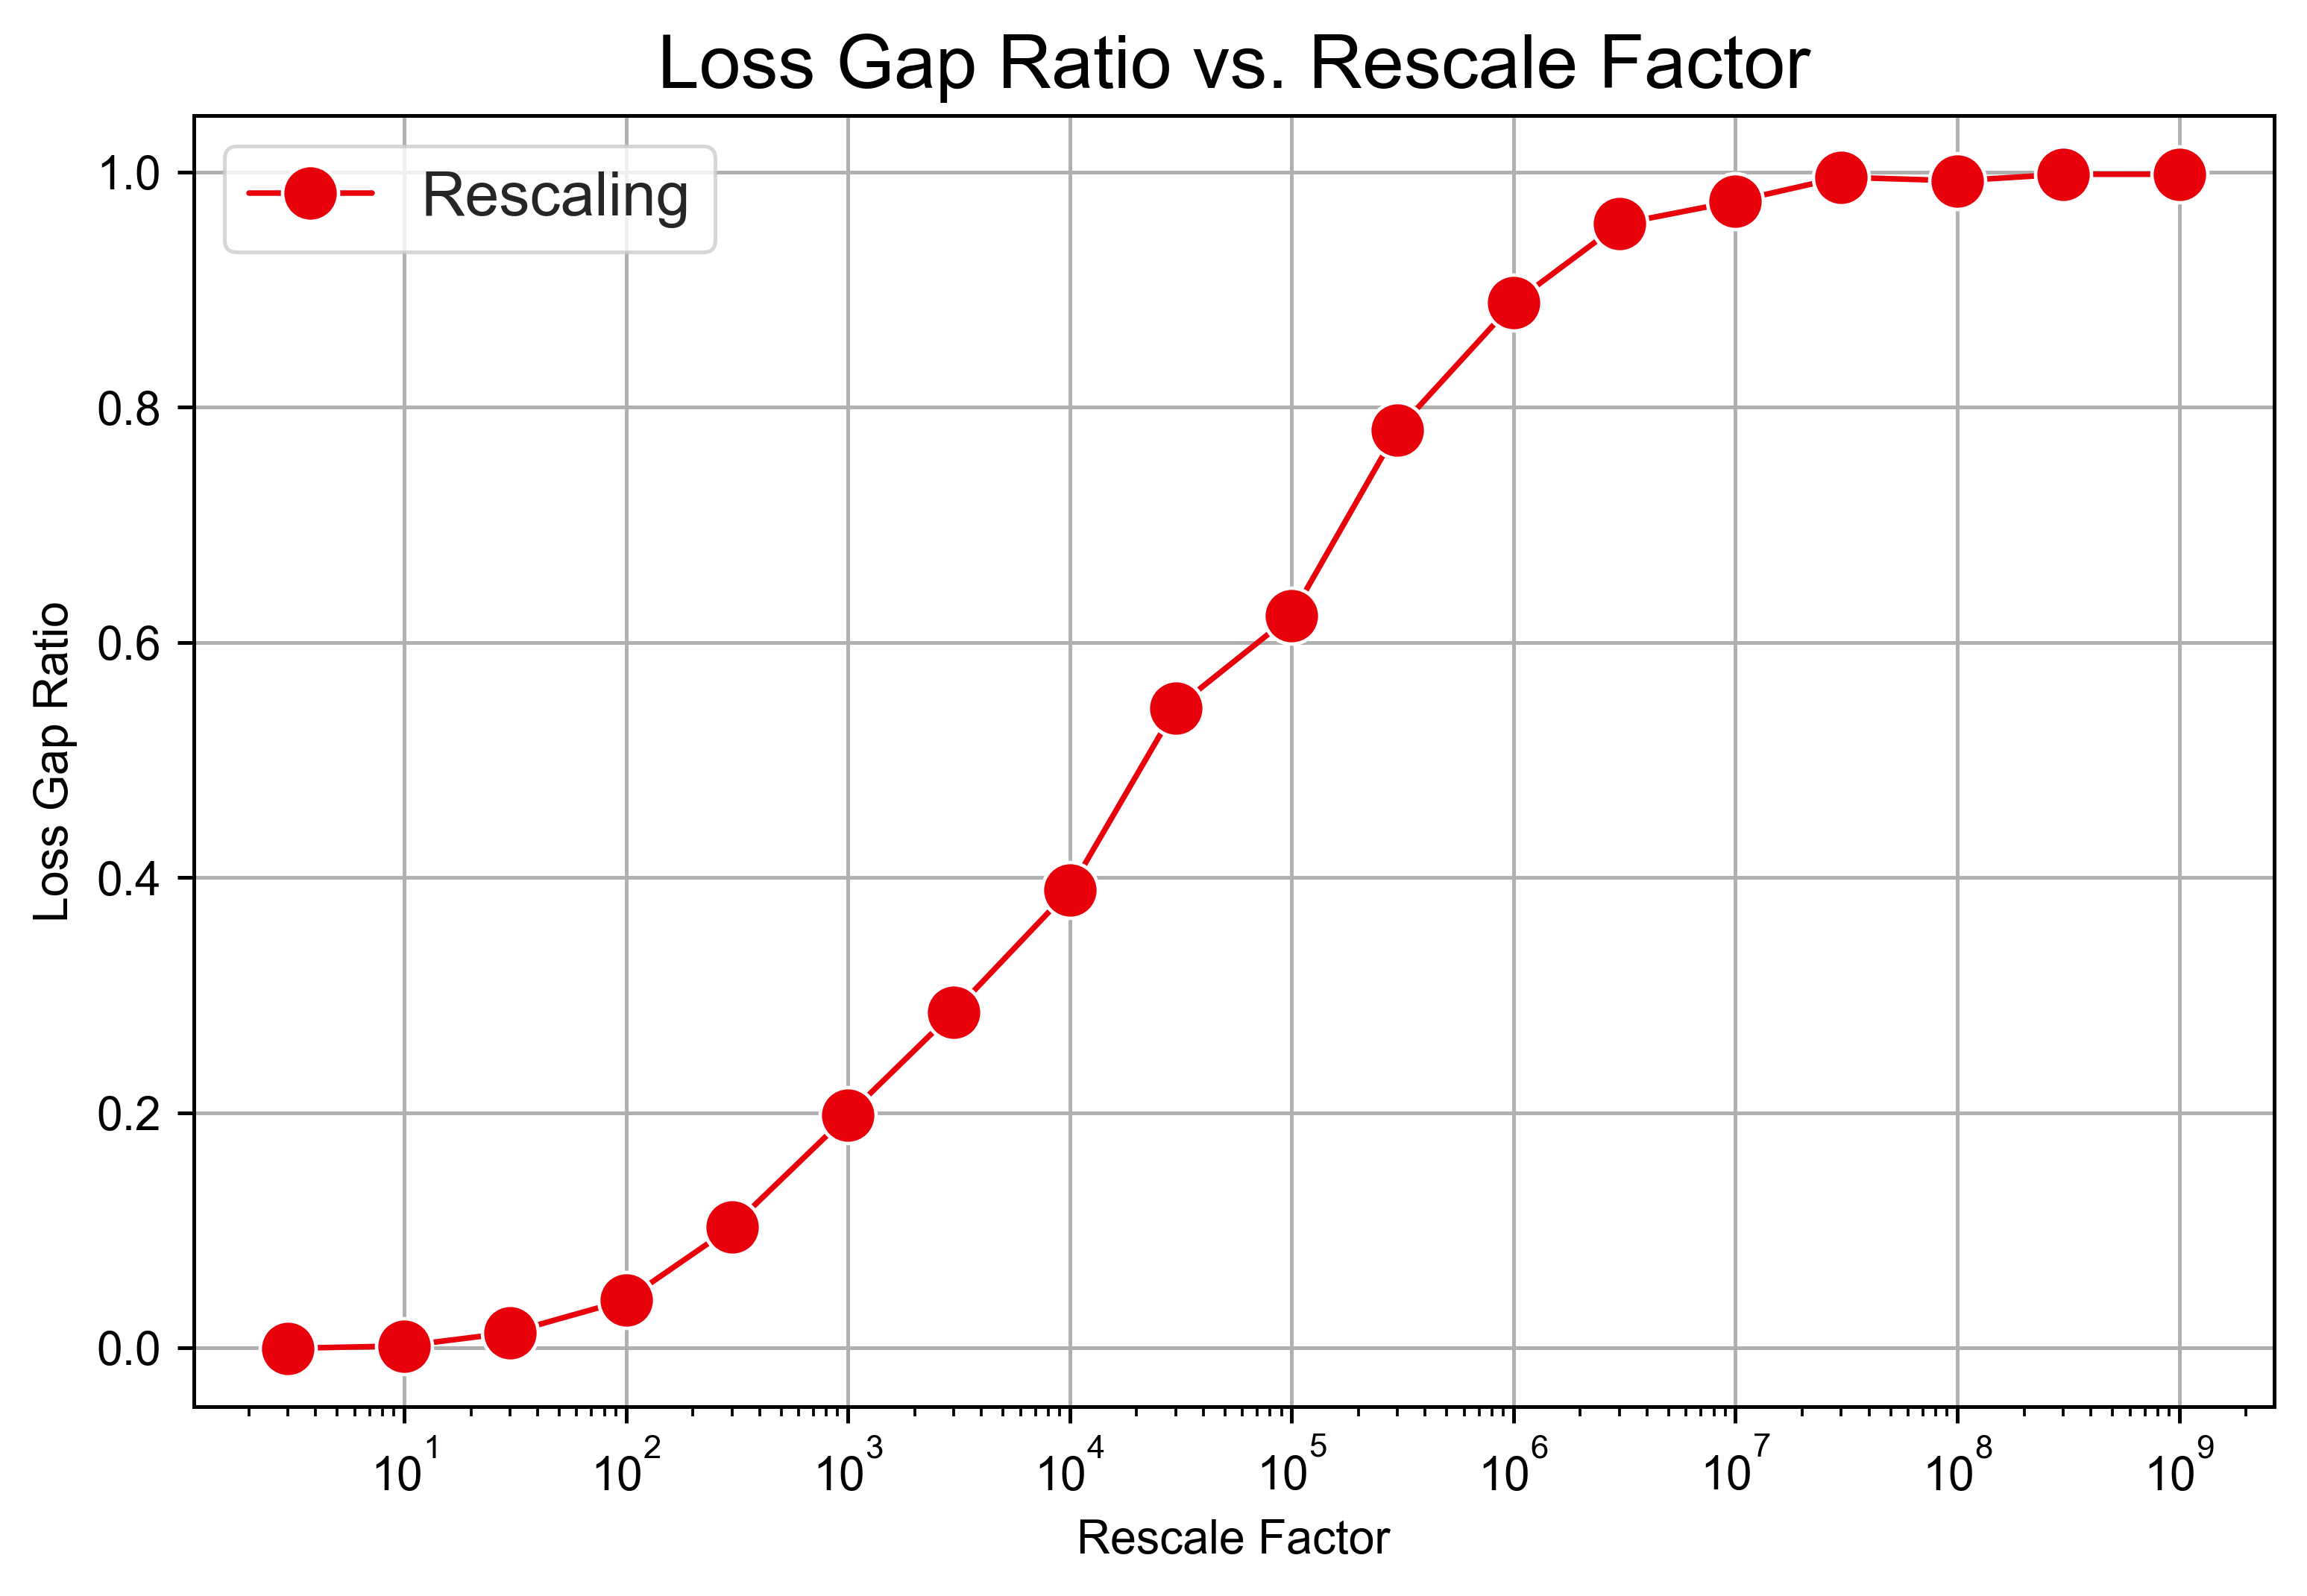

In [172]:
# That's a bit hard to read, so let's plot the rescaling data as a line plot of rescale factor to Loss Gap Ratio
chart_utils.initialize_plot_default()
sns.lineplot(x=[x[0] for x in unadaptability_results_rescale], y=[x[2] for x in unadaptability_results_rescale], color=color_rescale, label="Rescaling")
plt.title("Loss Gap Ratio vs. Rescale Factor")
plt.xlabel("Rescale Factor")
plt.ylabel("Loss Gap Ratio")
plt.xscale("log")
# plt.yscale("log")
plt.show()

Optimal parameters: L=1.0177, k=1.1305, x0=4.4059
Mean Squared Error: 0.0004


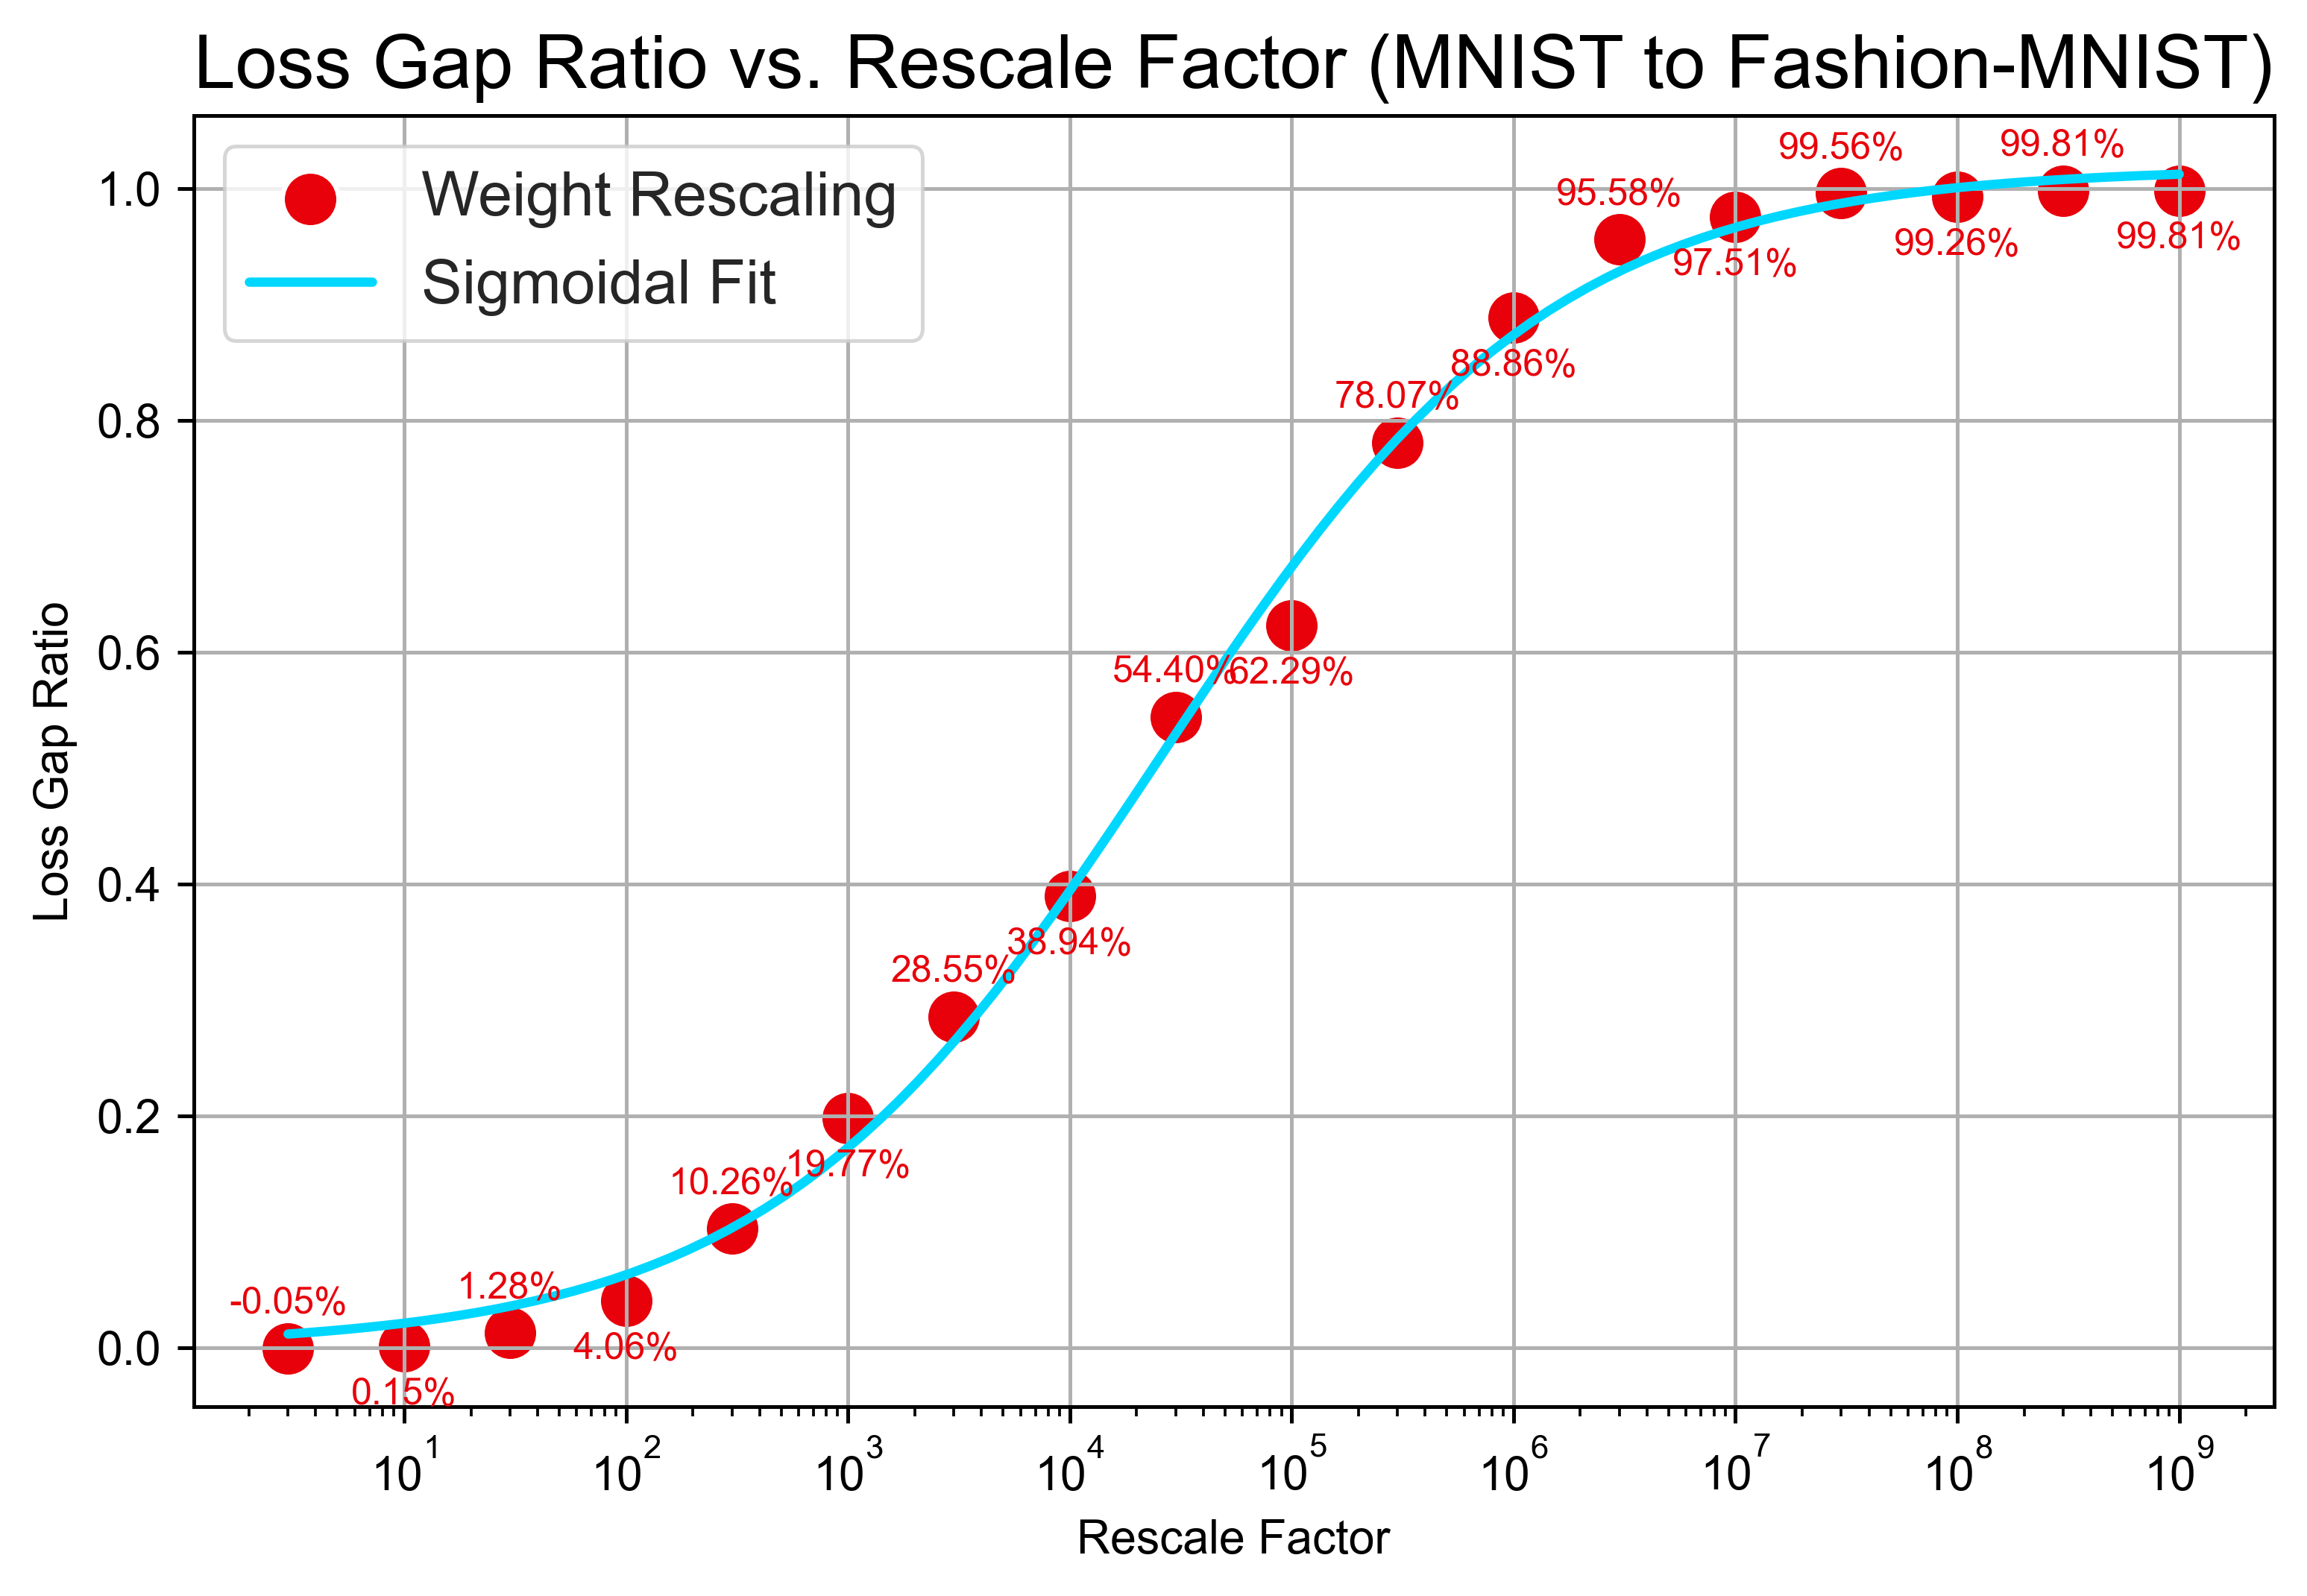

In [173]:
# Fit some sigmoidal curve to the rescaling data (with the log of the rescale factor)
from scipy.optimize import curve_fit
def sigmoid(x, L, k, x0):
    y = L / (1 + np.exp(-k*(x-x0)))
    return y

# Fit the sigmoidal curve
x = np.log10([x[0] for x in unadaptability_results_rescale])
y = [x[2] for x in unadaptability_results_rescale]
popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), 1, min(x)])
print(f"Optimal parameters: L={popt[0]:.4f}, k={popt[1]:.4f}, x0={popt[2]:.4f}")

# Rescale the fit back to the original scale
x_non_log = [10**x for x in x]
x_fit_log = np.linspace(min(x), max(x), 100)
y_fit_non_log = sigmoid(x_fit_log, *popt)
x_fit_non_log = [10**x for x in x_fit_log]

# Calculate MSE
mse = np.mean((y - sigmoid(x, *popt))**2)
print(f"Mean Squared Error: {mse:.4f}")

# Plot the sigmoidal curve
chart_utils.initialize_plot_default()
color_curve = chart_utils.get_color_from_palette(9)
sns.scatterplot(x=x_non_log, y=y, color=color_rescale, label="Weight Rescaling")
sns.lineplot(x=x_fit_non_log, y=y_fit_non_log, color=color_curve, label="Sigmoidal Fit", lw=2, marker="") 
# Add labels above and below the points (alternating)
for i, (rescale_factor, loss_gap_ratio) in enumerate(zip(x_non_log, y)):
    y_offset = 0.03 if i % 2 == 0 else -0.05    
    plt.text(rescale_factor, loss_gap_ratio + y_offset, f"{100 *loss_gap_ratio:.2f}%", fontsize=8, ha="center", color=color_rescale)
plt.title("Loss Gap Ratio vs. Rescale Factor (MNIST to Fashion-MNIST)")
plt.xlabel("Rescale Factor")
plt.ylabel("Loss Gap Ratio")
plt.xscale("log")
# plt.yscale("log")
plt.show()


Saved plot 'mnist_pruning_rescaling' to mnist_pruning_rescaling.pdf


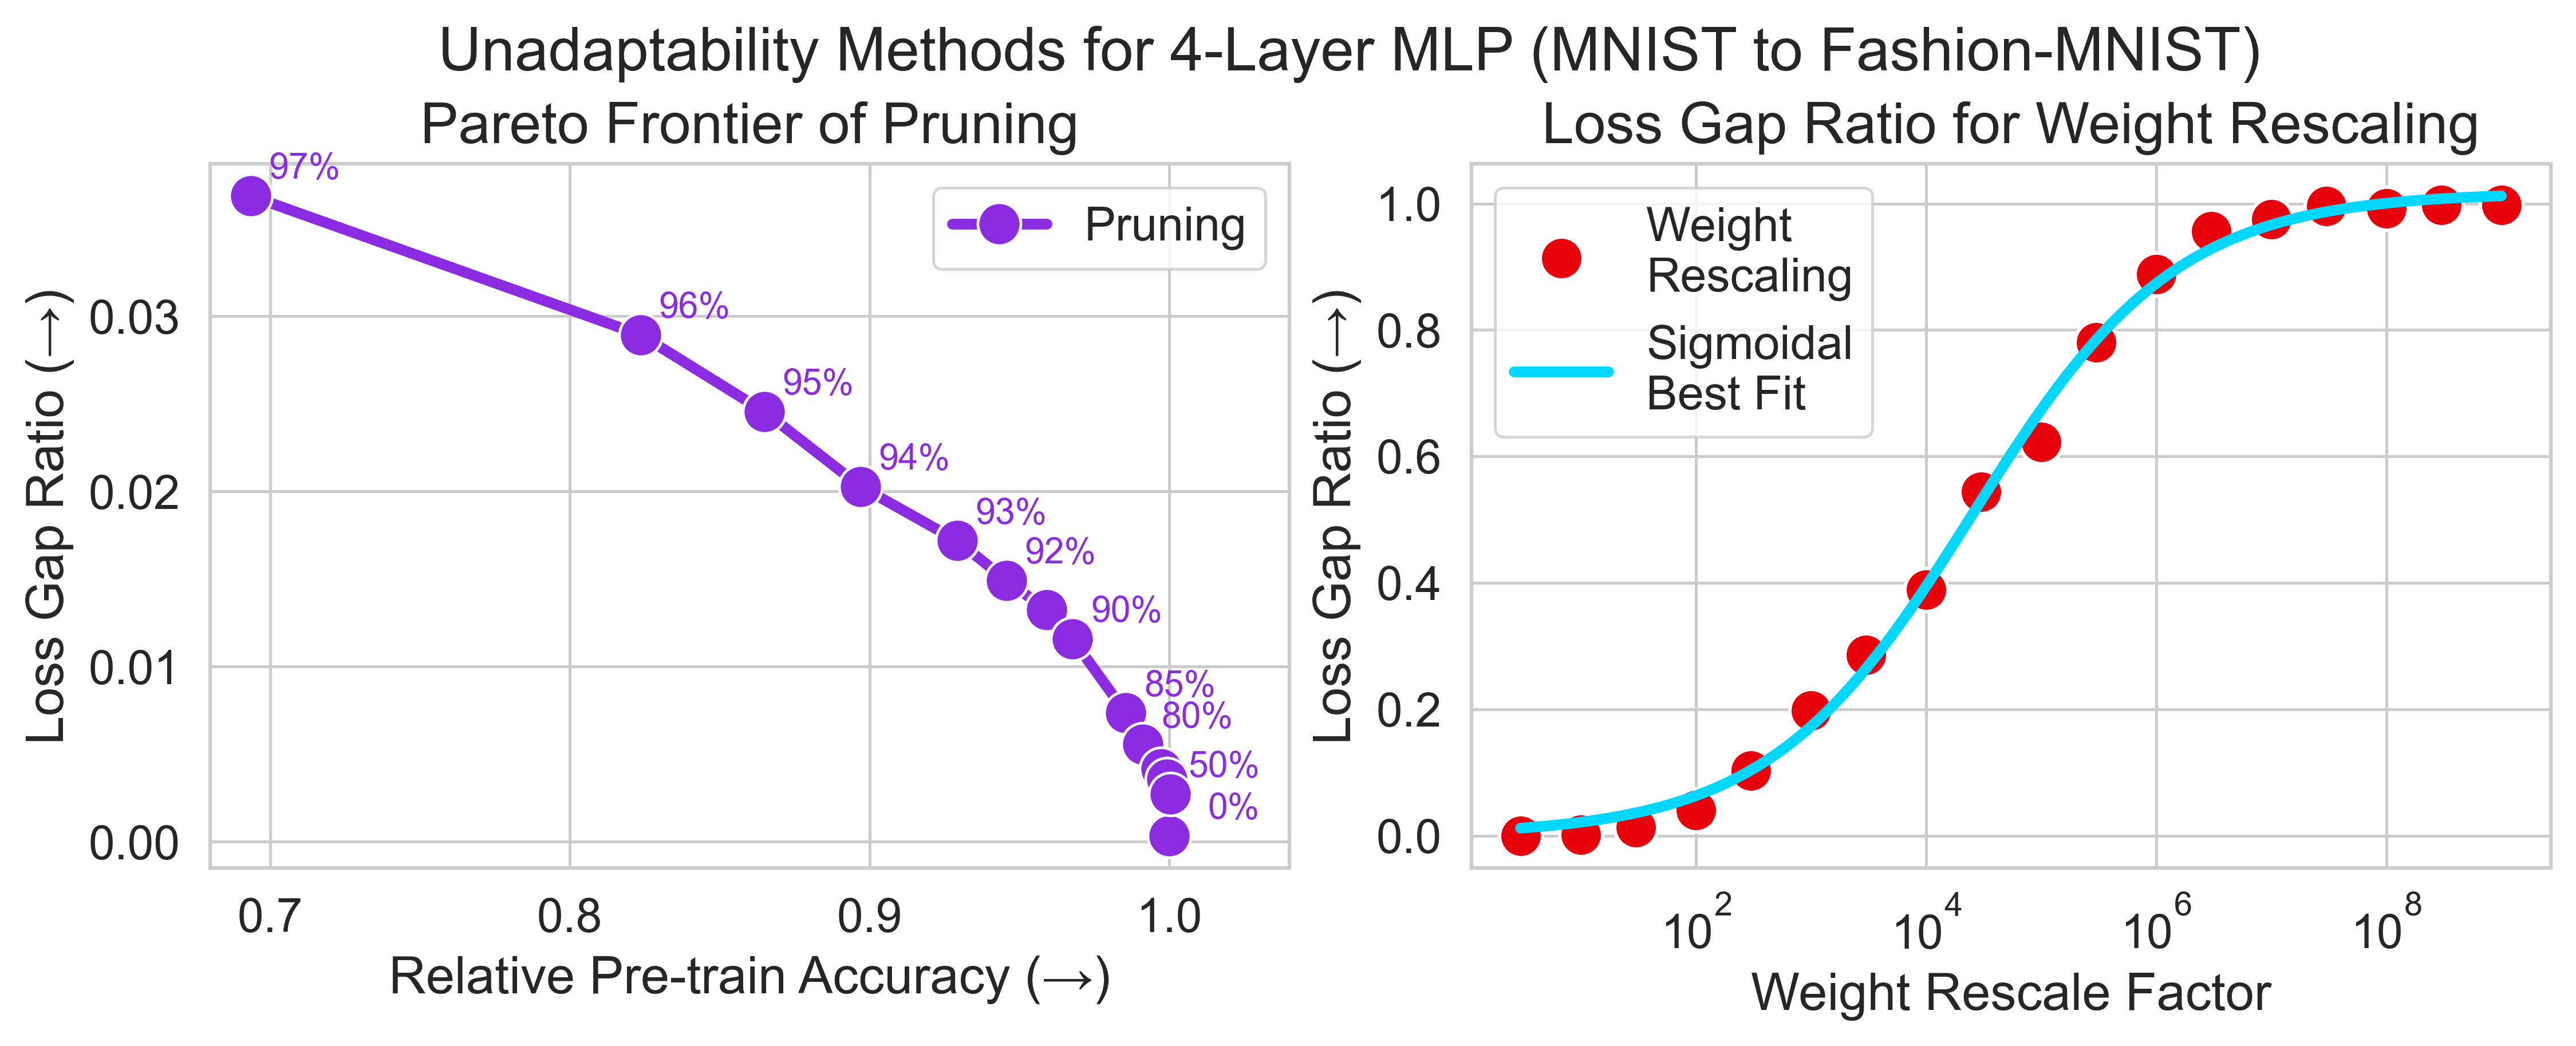

In [174]:
# Let's make a 2x1 subplot with the Pareto Frontier of Unadaptability via Pruning and the Loss Gap Ratio vs. Rescale Factor plots for the paper
linewidth = 3
plt.rcParams["lines.markersize"] = 12
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
chart_utils.initialize_plot_default()
# Space out the subplots
plt.subplots_adjust(wspace=0.3)
fig.tight_layout()
# Pareto Frontier of Unadaptability via Pruning
ax = axs[0]
sns.lineplot(x=[x[1] for x in unadaptability_results_pruning], y=[x[2] for x in unadaptability_results_pruning], color=color_prune, label="Pruning", ax=ax, lw=linewidth)
# Add labels
x_offset = 0.03
y_offset = 0.001
for i, (prune_ratio, mnist_accuracy_relative, loss_gap_ratio) in enumerate(unadaptability_results_pruning):
    # Skip some overalpping labels
    if i in [2, 3, 7]:
        continue
    ax.text(mnist_accuracy_relative + x_offset, loss_gap_ratio + y_offset, f"{prune_ratio * 100:.0f}%", fontsize=10, ha="right", color=color_prune)
ax.set_title("Pareto Frontier of Pruning")
ax.set_xlabel("Relative Pre-train Accuracy (→)")
ax.set_ylabel("Loss Gap Ratio (→)")
ax.set_xlim(0.68, 1.04)
ax.legend(loc="upper right")

# Loss Gap Ratio vs. Rescale Factor
ax = axs[1]
# Small points because small plots
sns.scatterplot(x=x_non_log, y=y, color=color_rescale, label="Weight\nRescaling", ax=ax)
sns.lineplot(x=x_fit_non_log, y=y_fit_non_log, color=color_curve, label="Sigmoidal\nBest Fit", marker="", lw=linewidth, ax=ax)
plt.xscale("log")
ax.set_title("Loss Gap Ratio for Weight Rescaling")
ax.set_xlabel("Weight Rescale Factor")
ax.set_ylabel("Loss Gap Ratio (→)")

plt.suptitle("Unadaptability Methods for 4-Layer MLP (MNIST to Fashion-MNIST)", y=1.075)


# Save as pdf
chart_utils.save_plot("../charts/mnist", "mnist_pruning_rescaling")

plt.show()


## How trivial is it to subvert weight rescaling?

First, can we just use a larger learning rate to cut down the loss gap ratio, or will fine-tuning actually be broken without unscaling the weights? 

In [175]:
# How trivial is it to subvert weight rescaling?
# First, can we just use a larger learning rate to cut down the loss gap ratio, or will fine-tuning actually be broken without unscaling the weights? 

# Create a 1e9x rescaled model (should get ~100% loss gap ratio)
model_rescaled_pt = copy.deepcopy(model_base_pt)
apply_weight_rescaling_to_model(model_rescaled_pt, rescale_factor = 1e9)

# For a range of learning rates, fine-tune the model, calculate LGR, and plot
learning_rates = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 2e-1, 3e-1, 5e-1, 1e0, 3e0, 7e0, 1e1, 3e1, 1e2]
lr_attack_lgrs = []
for learning_rate in learning_rates:
    print(f"Fine-tuning the model with lr={learning_rate:.0e}")
    model_rescaled_ft = copy.deepcopy(model_rescaled_pt)
    losses_rescaled_ft = train(model_rescaled_ft, device, fashion_train_loader, num_epochs=ft_epochs, learning_rate=learning_rate)
    loss_gap_ratio = calculate_loss_gap_ratio(losses_rescaled_ft, losses_base_ft)
    print(f"Loss Gap Ratio: {loss_gap_ratio * 100:.4f}%")
    lr_attack_lgrs.append(loss_gap_ratio)



Fine-tuning the model with lr=1e-03


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 4676325.490442
Loss Gap Ratio: 100.0000%
Fine-tuning the model with lr=3e-03


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 12596950.981462
Loss Gap Ratio: 99.6175%
Fine-tuning the model with lr=1e-02


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 41927316.777769
Loss Gap Ratio: 93.6158%
Fine-tuning the model with lr=3e-02


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 133841377.385829
Loss Gap Ratio: 57.2025%
Fine-tuning the model with lr=1e-01


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 1054483882.474441
Loss Gap Ratio: 54.3763%
Fine-tuning the model with lr=2e-01


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 4054547751.272338
Loss Gap Ratio: 47.6681%
Fine-tuning the model with lr=3e-01


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 9634377133.733391
Loss Gap Ratio: 47.9843%
Fine-tuning the model with lr=6e-01


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 33816601448.972549
Loss Gap Ratio: 53.3134%
Fine-tuning the model with lr=1e+00


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 100938846869.194077
Loss Gap Ratio: 49.2179%
Fine-tuning the model with lr=3e+00


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 753936410805.036133
Loss Gap Ratio: 54.2253%
Fine-tuning the model with lr=7e+00


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 3500619654729.398926
Loss Gap Ratio: 78.1778%
Fine-tuning the model with lr=1e+01


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 6309851104937.915039
Loss Gap Ratio: 91.5259%
Fine-tuning the model with lr=3e+01


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 27583993655675.718750
Loss Gap Ratio: 93.1505%
Fine-tuning the model with lr=1e+02


  0%|          | 0/469 [00:00<?, ?it/s]

Train Epoch: 1/1 (100.00%) Average Loss: 647769579.437278
Loss Gap Ratio: 99.2764%


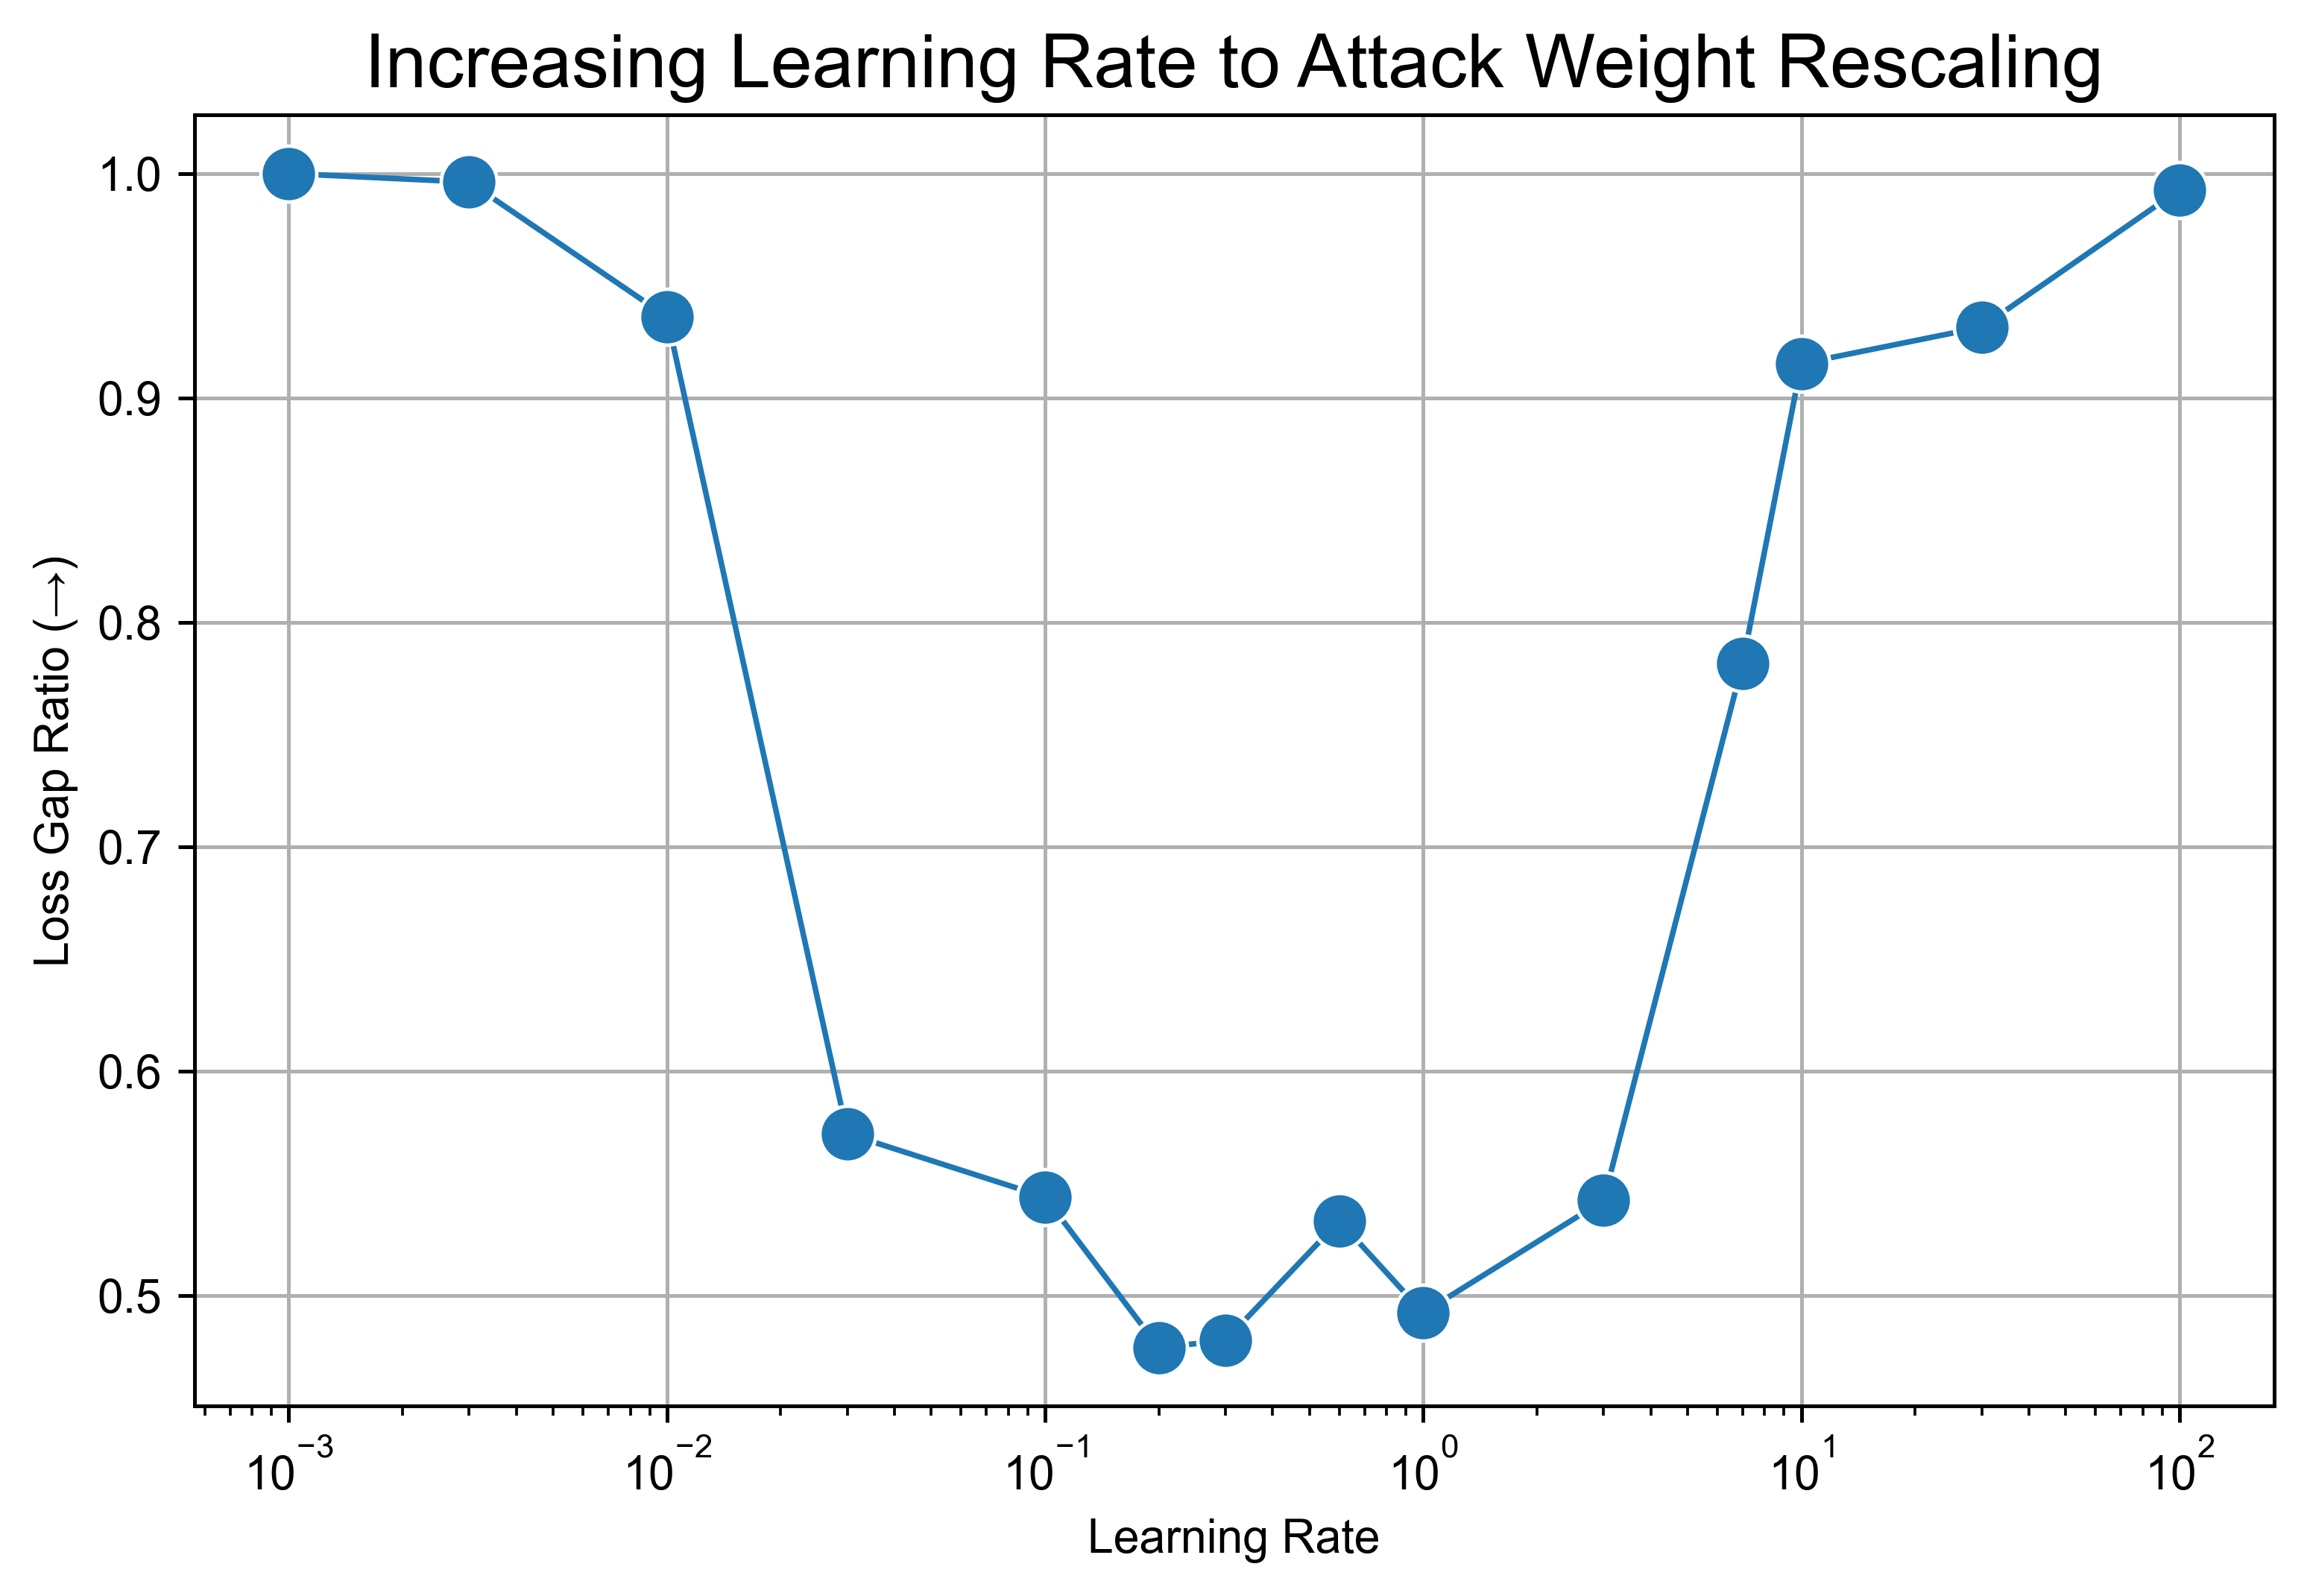

In [176]:

# Plot the LGR vs. learning rate
chart_utils.initialize_plot_default()
sns.lineplot(x=learning_rates, y=lr_attack_lgrs, marker="o")
plt.xscale("log")
# plt.yscale("log")
plt.title("Increasing Learning Rate to Attack Weight Rescaling")
plt.xlabel("Learning Rate")
plt.ylabel("Loss Gap Ratio (→)")
plt.show()